In [1]:
# Standard library imports
import json
from tqdm import tqdm

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# HDF5 handling
import h5py

print("All necessary modules imported successfully.")

All necessary modules imported successfully.


In [2]:
file_path = "../data/val/val_20_30.h5"
f = h5py.File(file_path)

In [3]:
f['subjets']

<HDF5 dataset "subjets": shape (403000,), type "|O">

In [4]:
class JetDataset(Dataset):
    def __init__(self, file_path, emb_dim, subset_size=None, transform=None):
        """
        Initializes the JetDataset with data from an HDF5 file.
        
        Parameters:
        - file_path (str): Path to the HDF5 file containing the dataset.
        - subset_size (int, optional): Number of samples to use from the dataset.
        - transform (callable, optional): Transform to apply to the features.
        """
        # print(f"Initializing JetDataset with file: {file_path}")
        
        # Load data from HDF5 file
        with h5py.File(file_path, 'r') as hdf:
            self.features = torch.tensor(hdf["particles/features"][:], dtype=torch.float32)
            self.subjets = [json.loads(subjet) for subjet in hdf["subjets"][:]]
        
        self.transform = transform
        
        # print(f"Raw dataset size: {len(self.subjets)} jets")
        # print(f"Feature shape: {self.features.shape}")
        
        # Filter jets with at least 10 real subjets
        self.filter_good_jets()
        
        if subset_size is not None:
            print(f"Applying subset size: {subset_size}")
            self.features = self.features[:subset_size]
            self.subjets = self.subjets[:subset_size]
        
        # print(f"Final dataset size: {len(self.subjets)} jets")

        self.emb_dim = emb_dim

    def filter_good_jets(self):
        """
        Filters the jets to keep only those with at least 10 real subjets.
        """
        print("Filtering good jets...")
        good_jets = []
        good_features = []
        
        for i in range(len(self.subjets)):
            num_real_subjets = self.get_num_real_subjets(self.subjets[i])
            if num_real_subjets >= 10:
                good_jets.append(self.subjets[i])
                good_features.append(self.features[i])

            # Uncomment the lines below to print progress every 1000 jets
            # if i % 1000 == 0:
            #     print(f"Processed {i} jets, found {len(good_jets)} good jets")
        
        self.subjets = good_jets
        self.features = torch.stack(good_features)
        # print(f"Filtered to {len(self.subjets)} good jets")
    
    @staticmethod
    def get_num_real_subjets(jet):
        """
        Counts and returns the number of real subjets in a given jet.
        
        Parameters:
        - jet (list): A list of subjets where each subjet is a dictionary.
        
        Returns:
        - int: Number of real subjets (those with num_ptcls > 0).
        """
        return sum(1 for subjet in jet if subjet['features']['num_ptcls'] > 0)

    def __len__(self):
        """
        Returns the total number of jets in the dataset.
        
        Returns:
        - int: Number of jets.
        """
        return len(self.subjets)

    def __getitem__(self, idx):
        """
        Retrieves the features and subjets for a given index and processes them.
        
        Parameters:
        - idx (int): Index of the jet to retrieve.
        
        Returns:
        - tuple: (features, subjets, subjet_mask, particle_mask)
          where `features` is the normalized feature tensor,
          `subjets` is the processed subjets tensor,
          `subjet_mask` is the mask for subjets,
          and `particle_mask` is the mask for particles.
        """
        features = self.features[idx]
        subjets = self.subjets[idx]
        subjets, subjet_mask, particle_mask = self.process_subjets(subjets)
        # subjets not normalized?
        if self.transform:
            features = self.transform(features)

        pos_emb = create_pos_emb(self.emb_dim, subjets)
        pos_emb = torch.tensor(pos_emb, dtype=torch.float32)
        
        features = normalize_features(features)
        
        if idx % 1000 == 0:
            # print(f"Getting item {idx}")
            # print(f"Features shape: {features.shape}")
            # print(f"Subjets shape: {subjets.shape}")
            # print(f"Subjet mask shape: {subjet_mask.shape}")
            # print(f"Particle mask shape: {particle_mask.shape}")
            # print(f"Number of non-empty subjets: {subjet_mask.sum().item()}")
            # print(f"Number of non-empty particles: {particle_mask.sum().item()}")
            pass

        return features, subjets, pos_emb, subjet_mask, particle_mask

    def process_subjets(self, subjets):
        """
        Processes subjets to create tensor representations and masks.
        
        Parameters:
        - subjets (list): List of subjets where each subjet is a dictionary.
        
        Returns:
        - tuple: (subjets, subjet_mask, particle_mask)
          where `subjets` is the tensor representation of subjets,
          `subjet_mask` is the mask for subjets,
          and `particle_mask` is the mask for particles.
        """
        if isinstance(subjets, torch.Tensor):
            subjets = subjets.tolist()

        if isinstance(subjets[0], list):
            subjets = [{'features': {'pT': s[0], 'eta': s[1], 'phi': s[2], 'num_ptcls': s[3]}, 'indices': s[4:]} for s in subjets]

        max_len = max(len(subjet['indices']) for subjet in subjets)
        subjet_tensors = []
        subjet_mask = []
        particle_mask = []
        
        for i, subjet in enumerate(subjets):
            feature_tensors = [torch.tensor([subjet['features'][k]], dtype=torch.float32).expand(max_len) for k in ['pT', 'eta', 'phi', 'num_ptcls']]
            features = torch.stack(feature_tensors, dim=0)
            indices = torch.tensor(subjet['indices'], dtype=torch.float32).unsqueeze(0).expand(features.size(0), -1)

            if indices.shape[1] < max_len:
                pad_len = max_len - indices.shape[1]
                indices = torch.nn.functional.pad(indices, (0, pad_len), 'constant', -1)

            combined = torch.cat([features, indices], dim=0)
            subjet_tensors.append(combined)
            
            is_empty = subjet['features']['num_ptcls'] == 0
            subjet_mask.append(0 if is_empty else 1)
            particle_mask.append([1 if i < len(subjet['indices']) else 0 for i in range(max_len)])
            
            if i % 100 == 0:
                # print(f"Processed subjet {i}")
                # print(f"Subjet features shape: {features.shape}")
                # print(f"Subjet indices shape: {indices.shape}")
                # print(f"Is empty: {is_empty}")
                pass

        subjets = torch.stack(subjet_tensors)
        subjet_mask = torch.tensor(subjet_mask, dtype=torch.float32)
        particle_mask = torch.tensor(particle_mask, dtype=torch.float32)
        
        # print(f"Processed subjets shape: {subjets.shape}")
        # print(f"Subjet mask shape: {subjet_mask.shape}")
        # print(f"Particle mask shape: {particle_mask.shape}")

        print("subjets shape", subjets.size())
        
        return subjets, subjet_mask, particle_mask


In [5]:
def custom_collate_fn(batch):
    """
    Custom collate function for DataLoader to handle variable-sized subjets and particles.
    
    Parameters:
    - batch (list): List of tuples where each tuple contains (features, subjets, subjet_mask, particle_mask).
    
    Returns:
    - tuple: (features, subjets, subjet_masks, particle_masks) where each element is a padded tensor.
    """
    print("Starting custom_collate_fn")
    
    # Unzip the batch to separate features, subjets, subjet_masks, and particle_masks
    features, subjets, sj_pes, subjet_masks, particle_masks = zip(*batch)
    
    # print(f"Batch size: {len(features)}")
    # print(f"Sample feature shape: {features[0].shape}")
    # print(f"Sample subjet shape: {subjets[0].shape}")
    # print(f"Sample subjet mask shape: {subjet_masks[0].shape}")
    # print(f"Sample particle mask shape: {particle_masks[0].shape}")
    
    # Stack features along a new dimension
    features = torch.stack(features)
    
    # Determine the maximum dimensions for padding
    max_subjets = max(s.size(0) for s in subjets)
    max_subjet_features = max(s.size(1) for s in subjets)
    max_subjet_length = max(s.size(2) for s in subjets)
    
    # print(f"Max subjets: {max_subjets}")
    # print(f"Max subjet features: {max_subjet_features}")
    # print(f"Max subjet length: {max_subjet_length}")
    
    padded_subjets = []
    padded_sj_pes = []
    padded_subjet_masks = []
    padded_particle_masks = []
    
    # Pad each element in the batch to match the maximum dimensions
    for i, (s, sj_pe, sm, pm) in enumerate(zip(subjets, sj_pes, subjet_masks, particle_masks)):
        if s.dim() == 2:
            s = s.unsqueeze(2)
        
        pad_subjets = max_subjets - s.size(0)
        pad_features = max_subjet_features - s.size(1)
        pad_length = max_subjet_length - s.size(2)
        padding = (0, pad_length, 0, pad_features, 0, pad_subjets)
        
        # Pad the subjets tensor
        padded_s = F.pad(s, padding, "constant", 0)
        padded_subjets.append(padded_s)

        # Pad the subjets pos emb
        padding_pe = F.pad(sj_pe, (0, pad_length, 0, pad_subjets), "constant", 0)
        padded_sj_pes.append(padding_pe)
        
        # Pad the subjet masks tensor
        padded_sm = F.pad(sm, (0, pad_subjets), "constant", 0)
        padded_subjet_masks.append(padded_sm)
        
        # Pad the particle masks tensor
        padded_pm = F.pad(pm, (0, pad_length, 0, pad_subjets), "constant", 0)
        padded_particle_masks.append(padded_pm)
        
        if i == 0:
            # print(f"Sample padded subjet shape: {padded_s.shape}")
            # print(f"Sample padded subjet mask shape: {padded_sm.shape}")
            # print(f"Sample padded particle mask shape: {padded_pm.shape}")
            pass
    
    # Stack the padded tensors
    subjets = torch.stack(padded_subjets)
    sj_pes = torch.stack(padded_sj_pes)
    subjet_masks = torch.stack(padded_subjet_masks)
    particle_masks = torch.stack(padded_particle_masks)
    
    # print(f"Final features shape: {features.shape}")
    # print(f"Final subjets shape: {subjets.shape}")
    # print(f"Final subjet masks shape: {subjet_masks.shape}")
    # print(f"Final particle masks shape: {particle_masks.shape}")
    
    return features, subjets, sj_pes, subjet_masks, particle_masks


## Check dataset fields

In [6]:
def get_1d_sincos_pos_emb(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)

    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [7]:
# position = torch.arange(max_len).unsqueeze(1)
# div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
# pe = torch.zeros(max_len, 1, d_model)
# pe[:, 0, 0::2] = torch.sin(position * div_term)
# pe[:, 0, 1::2] = torch.cos(position * div_term)
# self.register_buffer('pe', pe)

def create_pos_emb(emb_dim, ftrs):
    """
    features: Tensor [bs, N_sj, N_ptcl_ftr, N_ptcl]
    emb_size: Integer
    """
    # register pos_embedding
    N_sj, _, _ = ftrs.size()
    

    ptcl_eta = ftrs[:, 1, :]
    ptcl_phi = ftrs[:, 2, :]

    sj_eta = torch.mean(ptcl_eta, axis=-1)
    sj_phi = torch.mean(ptcl_phi, axis=-1)

    # process phi to impose physical distance
    sj_phi_star = torch.sin(sj_phi/2)
    
    # shift eta to avoid negative positions
    sj_eta += 3
    
    # calculate embedding
    emb_eta = get_1d_sincos_pos_emb(emb_dim//2, sj_eta)
    emb_phi_star = get_1d_sincos_pos_emb(emb_dim//2, sj_phi_star)
    
    emb = np.concatenate([emb_eta, emb_phi_star], axis=1)  # (H*W, D)
    return emb

In [8]:
def create_random_masks(batch_size, num_subjets, num_features, subjet_length, context_scale=0.7):
    """
    Creates random masks for context and target subjets.
    
    Parameters:
    - batch_size (int): Number of samples in a batch.
    - num_subjets (int): Number of subjets in each sample.
    - num_features (int): Number of features in each subjet.
    - subjet_length (int): Length of each subjet.
    - context_scale (float): Proportion of subjets to be used as context.
    
    Returns:
    - context_masks (torch.Tensor): Tensor of context masks.
    - target_masks (torch.Tensor): Tensor of target masks.
    """
    print(f"Creating random masks with batch_size={batch_size}, num_subjets={num_subjets}")
    context_masks = []
    target_masks = []

    for i in range(batch_size):
        # Randomly permute indices of subjets
        indices = torch.randperm(num_subjets)
        context_size = int(num_subjets * context_scale)
        context_indices = indices[:context_size]
        target_indices = indices[context_size:]

        # Initialize masks with zeros
        context_mask = torch.zeros(num_subjets, num_features, subjet_length)
        target_mask = torch.zeros(num_subjets, num_features, subjet_length)

        # Set mask values for context and target
        context_mask[context_indices] = 1
        target_mask[target_indices] = 1

        context_masks.append(context_mask)
        target_masks.append(target_mask)

        if i == 0:
            print(f"Sample context mask shape: {context_mask.shape}")
            print(f"Sample target mask shape: {target_mask.shape}")

    return torch.stack(context_masks), torch.stack(target_masks)

def normalize_features(features):
    """
    Normalizes the features tensor.
    
    Parameters:
    - features (torch.Tensor): Input features tensor.
    
    Returns:
    - normalized (torch.Tensor): Normalized features tensor.
    """
    # print("Normalizing features")
    mean = features.mean(dim=0, keepdim=True)
    std = features.std(dim=0, keepdim=True)
    std[std == 0] = 1e-8  # Prevent division by zero
    normalized = (features - mean) / std
    # print(f"Normalized features shape: {normalized.shape}")
    return normalized

def print_jet_details(jet, name):
    """
    Prints details of the given jet tensor.
    
    Parameters:
    - jet (torch.Tensor): Input jet tensor.
    - name (str): Name of the jet for identification.
    """
    print(f"\n{name} Jet Details:")
    print(f"Shape: {jet.shape}")
    print(f"Non-zero elements: {torch.count_nonzero(jet)}")
    print("\nFirst few elements:")
    print(jet[0, :5, :5])

def visualize_jet(subjets, mask=None, title="Jet Visualization"):
    """
    Visualizes the subjets in a scatter plot.
    
    Parameters:
    - subjets (torch.Tensor): Tensor of subjets.
    - mask (torch.Tensor, optional): Mask tensor for filtering subjets.
    - title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    valid_points = False
    for i in range(subjets.size(0)):
        if mask is None or mask[i].any():
            eta = subjets[i, 1, 0].item()
            phi = subjets[i, 2, 0].item()
            pT = subjets[i, 0, 0].item()
            if pT > 0:
                ax.scatter(eta, phi, s=pT * 5, alpha=0.7)
                valid_points = True
    
    ax.set_xlabel('Eta')
    ax.set_ylabel('Phi')
    ax.set_title(title)
    
    if valid_points and ax.collections:
        plt.colorbar(ax.collections[0], label='pT')
    else:
        print(f"No valid points to display for {title}")
    
    plt.show()

def visualize_context_and_targets(subjets, context_mask, target_mask):
    """
    Visualizes context and target subjets in a scatter plot.
    
    Parameters:
    - subjets (torch.Tensor): Tensor of subjets.
    - context_mask (torch.Tensor): Mask tensor for context subjets.
    - target_mask (torch.Tensor): Mask tensor for target subjets.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

    def scatter_jet(ax, jet_data, mask, title):
        for i in range(jet_data.size(0)):
            if mask[i, 0, 0].item() > 0:  # Check only the first element of each subjet
                eta = jet_data[i, 1, 0].item()
                phi = jet_data[i, 2, 0].item()
                pT = jet_data[i, 0, 0].item()
                if pT > 0:
                    scatter = ax.scatter(eta, phi, s=pT * 5, alpha=0.7)
        ax.set_xlabel('Eta')
        ax.set_ylabel('Phi')
        ax.set_title(title)
        if ax.collections:
            plt.colorbar(ax.collections[0], ax=ax, label='pT')

    scatter_jet(ax1, subjets, torch.ones_like(context_mask), "Full Jet")
    scatter_jet(ax2, subjets, context_mask, "Context Subjets")
    scatter_jet(ax3, subjets, target_mask, "Target Subjets")

    plt.tight_layout()
    plt.show()

def visualize_predictions_vs_ground_truth(subjets, pred_repr, title="Ground Truth vs Predictions"):
    """
    Visualizes ground truth and predicted subjets in a scatter plot.
    
    Parameters:
    - subjets (torch.Tensor): Ground truth subjets tensor.
    - pred_repr (torch.Tensor): Predicted subjets tensor.
    - title (str): Title of the plot.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    def scatter_jet(ax, subjets, title):
        valid_points = False
        for i in range(subjets.size(0)):
            eta = subjets[i, 1, 0].item()
            phi = subjets[i, 2, 0].item()
            pT = subjets[i, 0, 0].item()
            if pT > 0:
                ax.scatter(eta, phi, s=pT * 5, alpha=0.7)
                valid_points = True
        ax.set_xlabel('Eta')
        ax.set_ylabel('Phi')
        ax.set_title(title)
        if valid_points and ax.collections:
            plt.colorbar(ax.collections[0], label='pT')

    scatter_jet(ax1, subjets, "Ground Truth")
    scatter_jet(ax2, pred_repr, "Predictions")

    plt.suptitle(title)
    plt.show()

def visualize_training_loss(train_losses):
    """
    Plots the training loss over epochs.
    
    Parameters:
    - train_losses (list of float): List of training loss values.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def visualize_sample_prediction(train_loader, model, device, step=0):
    """
    Visualizes a sample prediction after training.
    
    Parameters:
    train_loader (DataLoader): DataLoader for the training data.
    model (IJEPA): The trained model.
    device (torch.device): Device to run the model on (CPU or GPU).
    step (int): Step number for labeling the visualization (default: 0).
    """
    # Print a message indicating the start of sample prediction visualization
    print("Visualizing sample prediction")

    # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    model.eval()
    
    # Disable gradient computation for efficiency
    with torch.no_grad():
        # Get the next batch of data from the train_loader
        sample_batch = next(iter(train_loader))

        # Unpack the batch to get subjets, subjet masks, and particle masks
        _, sample_subjets, sample_subjet_masks, sample_particle_masks = sample_batch

        # Move the tensors to the specified device (CPU or GPU)
        sample_subjets = sample_subjets.to(device)
        sample_subjet_masks = sample_subjet_masks.to(device)
        sample_particle_masks = sample_particle_masks.to(device)

        # Get the dimensions of the sample_subjets tensor
        batch_size, num_subjets, num_features, subjet_length = sample_subjets.size()

        # Create random context and target masks
        context_masks, target_masks = create_random_masks(batch_size, num_subjets, num_features, subjet_length)

        # Move the masks to the specified device (CPU or GPU)
        context_masks = context_masks.to(device)
        target_masks = target_masks.to(device)

        # Apply the masks to the sample subjets to create context and target subjets
        context_subjets = sample_subjets * context_masks
        target_subjets = sample_subjets * target_masks

        # Feed the context and target subjets into the model to get the predicted and target representations
        pred_repr, target_repr, context_repr_shape, target_repr_shape = model(context_subjets, target_subjets)

        # Print the shapes of the final context and target representations
        print(f"Final context representation shape: {context_repr_shape}")
        print(f"Final target representation shape: {target_repr_shape}")

        # Visualize the ground truth vs predictions for the first item in the batch
        visualize_predictions_vs_ground_truth(sample_subjets[0].cpu(), pred_repr[0].cpu(), title=f"Final Model: Ground Truth vs Predictions (Step {step})")



## get a sample from dataloader

In [9]:
try:
    print("Loading dataset")
    train_dataset = JetDataset("../data/val/val_20_30.h5", subset_size = 1000, emb_dim=384)  # Use only 1000 samples    
except Exception as e:
    print(f"Error loading dataset: {e}")

print("Creating DataLoader")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

Loading dataset
Filtering good jets...
Applying subset size: 1000
Creating DataLoader


In [10]:
train_iter = iter(train_loader)

In [11]:
_, subjets, sj_pe, subjet_masks, particle_masks= next(train_iter)

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

In [12]:
subjets.size()

torch.Size([32, 20, 8, 30])

In [13]:
sj_pe.size()

torch.Size([32, 20, 384])

In [14]:
class IJEPA(nn.Module):
    """
    IJEPA model class that uses a transformer encoder for context and target representations
    and predicts representations for masked parts of the input.
    """
    
    def __init__(self, input_dim, embed_dim, depth, num_heads, mlp_ratio, dropout=0.1, max_seq_len=1024):
        """
        Initializes the IJEPA model.
        
        Parameters:
        - input_dim (int): The dimension of the input features.
        - embed_dim (int): The dimension of the embedding space.
        - depth (int): The number of layers in the transformer encoder.
        - num_heads (int): The number of attention heads in the transformer encoder.
        - mlp_ratio (float): The ratio of the hidden dimension in the MLP layer relative to the embedding dimension.
        - dropout (float): The dropout rate.
        - max_seq_len (int): The maximum sequence length for positional embeddings.
        """
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        
        print(f"Initializing IJEPA with input_dim={input_dim}, embed_dim={embed_dim}")
        
        # Linear layer to project input features to the embedding dimension
        self.embedding = nn.Linear(input_dim, embed_dim)
        # Positional embeddings to encode the position information
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, embed_dim))
        
        # Transformer encoders for context and target
        self.context_encoder = self.create_encoder(embed_dim, depth, num_heads, mlp_ratio, dropout)
        self.target_encoder = self.create_encoder(embed_dim, depth, num_heads, mlp_ratio, dropout)
        
        # Predictor MLP to transform the context representations to match the input dimension
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, input_dim)
        )

    def create_encoder(self, embed_dim, depth, num_heads, mlp_ratio, dropout):
        """
        Creates a transformer encoder.
        
        Parameters:
        - embed_dim (int): The dimension of the embedding space.
        - depth (int): The number of layers in the transformer encoder.
        - num_heads (int): The number of attention heads in the transformer encoder.
        - mlp_ratio (float): The ratio of the hidden dimension in the MLP layer relative to the embedding dimension.
        - dropout (float): The dropout rate.
        
        Returns:
        - nn.TransformerEncoder: A transformer encoder.
        """
        return nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                       dim_feedforward=int(embed_dim * mlp_ratio), 
                                       dropout=dropout),
            num_layers=depth
        )

    def forward(self, context, target, pos_emb):
        """
        Forward pass of the IJEPA model.
        
        Parameters:
        - context (torch.Tensor): The context input tensor.
        - target (torch.Tensor): The target input tensor.
        
        Returns:
        - pred_repr (torch.Tensor): The predicted representations for the masked parts.
        - target_repr (torch.Tensor): The encoded target representations.
        - context_repr_shape (torch.Size): The shape of the context representations.
        - target_repr_shape (torch.Size): The shape of the target representations.
        """
        print("Starting IJEPA forward pass")
        batch_size, num_subjets, num_features, subjet_length = context.size()
        
        print(f"Input context shape: {context.shape}")
        print(f"Input target shape: {target.shape}")
        
        # Flatten the context and target tensors
        context = context.view(batch_size, num_subjets, -1)
        target = target.view(batch_size, num_subjets, -1)
        
        print(f"Reshaped context shape: {context.shape}")
        print(f"Reshaped target shape: {target.shape}")
        
        # Apply the embedding layer
        context = self.embedding(context)
        target = self.embedding(target)
        
        print(f"Embedded context shape: {context.shape}")
        print(f"Embedded target shape: {target.shape}")
        
        # Add positional embeddings
        print(context.size(), pos_emb.size())
        context += pos_emb[:, :num_subjets]
        target += pos_emb[:, :num_subjets]
        
        print("Applying context encoder")
        # Encode the context representations
        context_repr = self.context_encoder(context.transpose(0, 1)).transpose(0, 1)
        print("Applying target encoder")
        # Encode the target representations with no gradient calculation
        with torch.no_grad():
            target_repr = self.target_encoder(target.transpose(0, 1)).transpose(0, 1)
        
        print(f"Context encoder output shape: {context_repr.shape}")
        print(f"Target encoder output shape: {target_repr.shape}")
        
        print("Applying predictor")
        # Predict the representations for the masked parts
        pred_repr = self.predictor(context_repr)
        print(f"Predictor output shape (before reshaping): {pred_repr.shape}")
        
        # Reshape the predicted and target representations to match the input dimensions
        pred_repr = pred_repr.view(batch_size, num_subjets, num_features, subjet_length)
        target_repr = self.predictor(target_repr).view(batch_size, num_subjets, num_features, subjet_length)
        
        print(f"Final predicted representation shape: {pred_repr.shape}")
        print(f"Final target representation shape: {target_repr.shape}")
        
        return pred_repr, target_repr, context_repr.shape, target_repr.shape

In [15]:
def train_step(model, subjets, pos_embs, subjet_masks, particle_masks, optimizer, device, step):
    """
    Performs a single training step for the IJEPA model.
    
    Parameters:
    - model (nn.Module): The IJEPA model.
    - subjets (torch.Tensor): The input subjets tensor.
    - subjet_masks (torch.Tensor): The mask tensor for the subjets.
    - particle_masks (torch.Tensor): The mask tensor for the particles.
    - optimizer (torch.optim.Optimizer): The optimizer.
    - device (torch.device): The device to run the training on (CPU or GPU).
    - step (int): The current training step number.
    
    Returns:
    - loss.item() (float): The loss value for the current training step.
    """
    print(f"\nStarting training step {step}")
    batch_size, num_subjets, num_features, subjet_length = subjets.size()
    print(f"Input shapes - Subjets: {subjets.shape}, Subjet masks: {subjet_masks.shape}, Particle masks: {particle_masks.shape}")
    
    # Create random masks for context and target
    context_masks, target_masks = create_random_masks(batch_size, num_subjets, num_features, subjet_length)
    
    # Move masks and inputs to the appropriate device
    context_masks = context_masks.to(device)
    target_masks = target_masks.to(device)
    subjet_masks = subjet_masks.to(device)
    particle_masks = particle_masks.to(device)
    
    print(f"Mask shapes - Context: {context_masks.shape}, Target: {target_masks.shape}")
    
    # Apply masks to the input subjets
    context_subjets = subjets * context_masks
    target_subjets = subjets * target_masks
    
    print(f"Context subjets shape: {context_subjets.shape}")
    print(f"Target subjets shape: {target_subjets.shape}")
    
    # Print details for debugging every 100 steps
    if step % 100 == 0:
        print_jet_details(subjets[0].cpu(), "FULL")
        print_jet_details(context_subjets[0].cpu(), "Context")
        print_jet_details(target_subjets[0].cpu(), "Target")
        
        try:
            visualize_context_and_targets(subjets[0].cpu(), context_masks[0].cpu(), target_masks[0].cpu())
        except Exception as e:
            print(f"Visualization error at step {step}: {e}")
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    print("Forwarding through model")
    # Forward pass through the model
    pred_repr, _, context_repr_shape, target_repr_shape = model(context_subjets, target_subjets, pos_embs)  # Use full subjets as target
    
    print(f"Predicted representation shape: {pred_repr.shape}")
    print(f"Number of dimensions in predicted representation: {pred_repr.dim()}")
    print(f"Context representation shape: {context_repr_shape}")
    print(f"Target representation shape: {target_repr_shape}")
    
    # Apply masks to the loss calculation
    subjet_masks_expanded = subjet_masks.unsqueeze(-1).unsqueeze(-1).expand_as(target_masks)
    particle_masks_expanded = particle_masks.unsqueeze(2).expand_as(target_masks)
    combined_mask = target_masks * subjet_masks_expanded * particle_masks_expanded
    print(f"Combined mask shape: {combined_mask.shape}")
    
    # Check if the shapes match
    if pred_repr.shape != subjets.shape:
        print(f"Warning: Shape mismatch - pred_repr: {pred_repr.shape}, subjets: {subjets.shape}")
    
    if pred_repr.shape != combined_mask.shape:
        print(f"Warning: Shape mismatch - pred_repr: {pred_repr.shape}, combined_mask: {combined_mask.shape}")
    
    # Compute the masked mean squared error loss
    loss = F.mse_loss(pred_repr * combined_mask, subjets * combined_mask)
    print(f"Calculated loss: {loss.item()}")
    
    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    # Print and visualize predictions every 500 steps
    if step % 500 == 0:
        print_jet_details(pred_repr[0].cpu(), "Predicted")
        visualize_predictions_vs_ground_truth(subjets[0].cpu(), pred_repr[0].cpu(), title=f"Ground Truth vs Predictions (Step {step})")
        print(f"Context representation shape: {context_repr_shape}")
        print(f"Target representation shape: {target_repr_shape}")
        
    return loss.item()


Starting main program
Using device: cuda
Loading dataset
Error loading dataset: JetDataset.__init__() missing 1 required positional argument: 'emb_dim'
Creating DataLoader
Initializing model
Initializing IJEPA with input_dim=240, embed_dim=384
Starting training for 10 epochs


Epoch 1/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([23, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

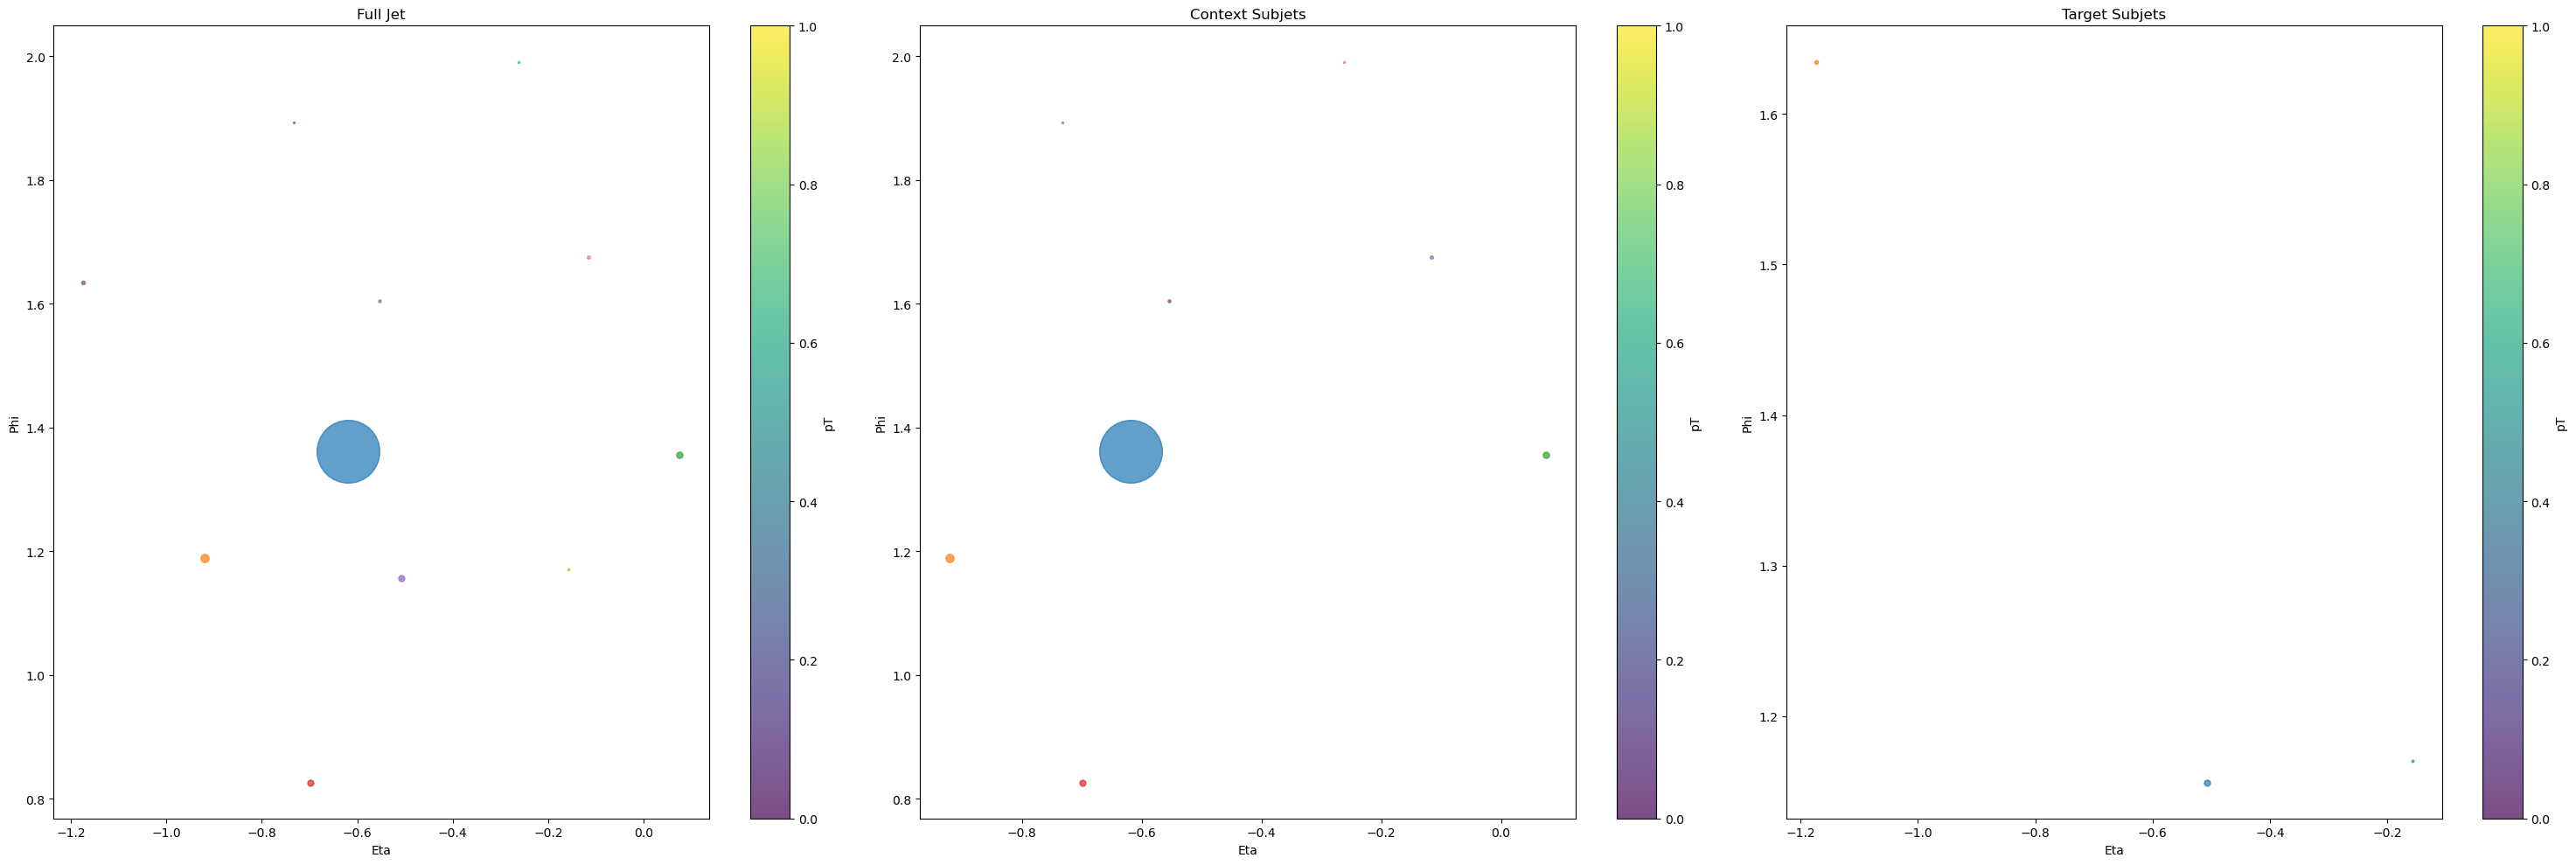

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 23, 8, 30])
Input target shape: torch.Size([32, 23, 8, 30])
Reshaped context shape: torch.Size([32, 23, 240])
Reshaped target shape: torch.Size([32, 23, 240])
Embedded context shape: torch.Size([32, 23, 384])
Embedded target shape: torch.Size([32, 23, 384])
torch.Size([32, 23, 384]) torch.Size([32, 23, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 23, 384])
Target encoder output shape: torch.Size([32, 23, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 23, 240])
Final predicted representation shape: torch.Size([32, 23, 8, 30])
Final target representation shape: torch.Size([32, 23, 8, 30])
Predicted representation shape: torch.Size([32, 23, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 23, 384])
Target representation shape: torch.Size([32, 23, 8, 30]

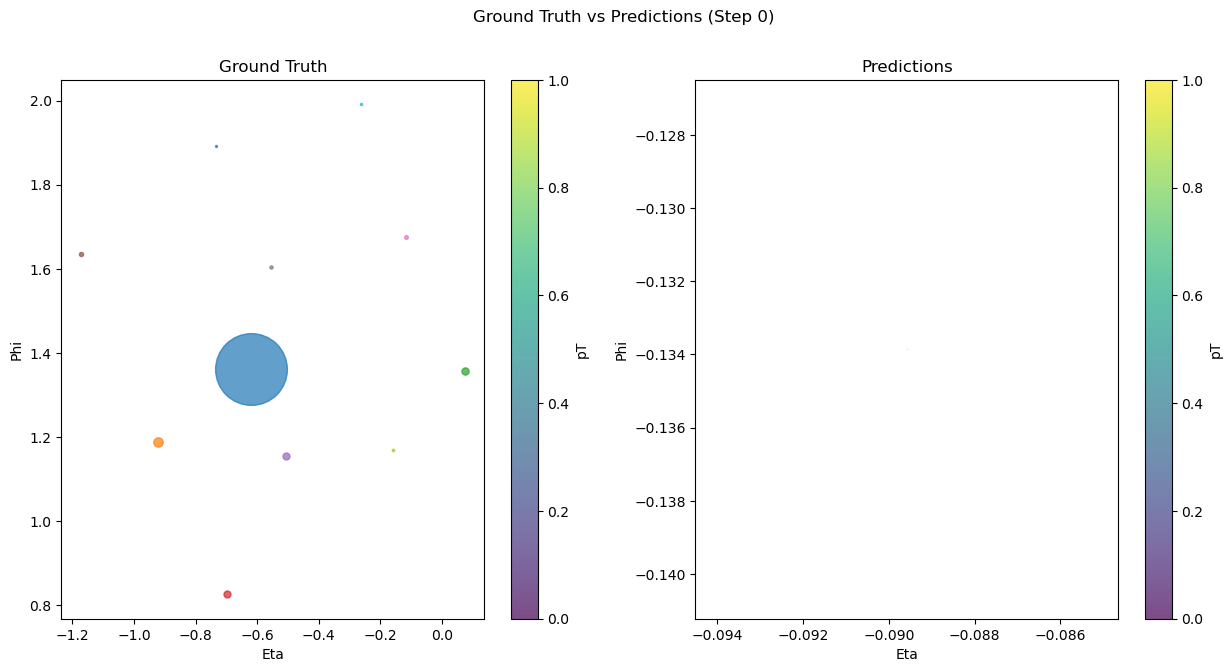

Epoch 1/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:02<00:29,  1.01it/s, loss=377]

Context representation shape: torch.Size([32, 23, 384])
Target representation shape: torch.Size([32, 23, 8, 30])

Epoch 1, Step 0, Loss: 401.4446
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 1/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:11,  2.48it/s, loss=322]

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

Epoch 1/10:  19%|█████████████████████████████▎                                                                                                                              | 6/32 [00:02<00:06,  4.20it/s, loss=526]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 

Epoch 1/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.04it/s, loss=341]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 1/10:  28%|███████████████████████████████████████████▉                                                                                                                | 9/32 [00:03<00:03,  6.44it/s, loss=338]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 188.2325897216797
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 1/10:  34%|█████████████████████████████████████████████████████▎                                                                                                     | 11/32 [00:03<00:02,  7.39it/s, loss=447]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 9
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 

Epoch 1/10:  38%|██████████████████████████████████████████████████████████▏                                                                                                | 12/32 [00:03<00:02,  7.71it/s, loss=380]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 11
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape

Epoch 1/10:  44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 14/32 [00:03<00:02,  8.12it/s, loss=527]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 1/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:01,  8.33it/s, loss=357]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 261.74676513671875
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.

Epoch 1/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:04<00:01,  8.45it/s, loss=308]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 16
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.S

Epoch 1/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 19/32 [00:04<00:01,  8.47it/s, loss=344]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 18
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape

Epoch 1/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  8.46it/s, loss=264]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 1/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  8.50it/s, loss=372]

Applying target encoder
Context encoder output shape: torch.Size([32, 22, 384])
Target encoder output shape: torch.Size([32, 22, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 22, 240])
Final predicted representation shape: torch.Size([32, 22, 8, 30])
Final target representation shape: torch.Size([32, 22, 8, 30])
Predicted representation shape: torch.Size([32, 22, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 22, 384])
Target representation shape: torch.Size([32, 22, 8, 30])
Combined mask shape: torch.Size([32, 22, 8, 30])
Calculated loss: 307.6163635253906
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 1/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 25/32 [00:05<00:00,  8.53it/s, loss=503]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 23
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Res

Epoch 1/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 26/32 [00:05<00:00,  8.53it/s, loss=504]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 25
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch

Epoch 1/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28/32 [00:05<00:00,  8.51it/s, loss=326]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 1/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 30/32 [00:05<00:00,  8.50it/s, loss=349]

Context encoder output shape: torch.Size([32, 24, 384])
Target encoder output shape: torch.Size([32, 24, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 24, 240])
Final predicted representation shape: torch.Size([32, 24, 8, 30])
Final target representation shape: torch.Size([32, 24, 8, 30])
Predicted representation shape: torch.Size([32, 24, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 24, 384])
Target representation shape: torch.Size([32, 24, 8, 30])
Combined mask shape: torch.Size([32, 24, 8, 30])
Calculated loss: 205.2556915283203
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.51it/s, loss=256]


subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 30
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.S

Epoch 2/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

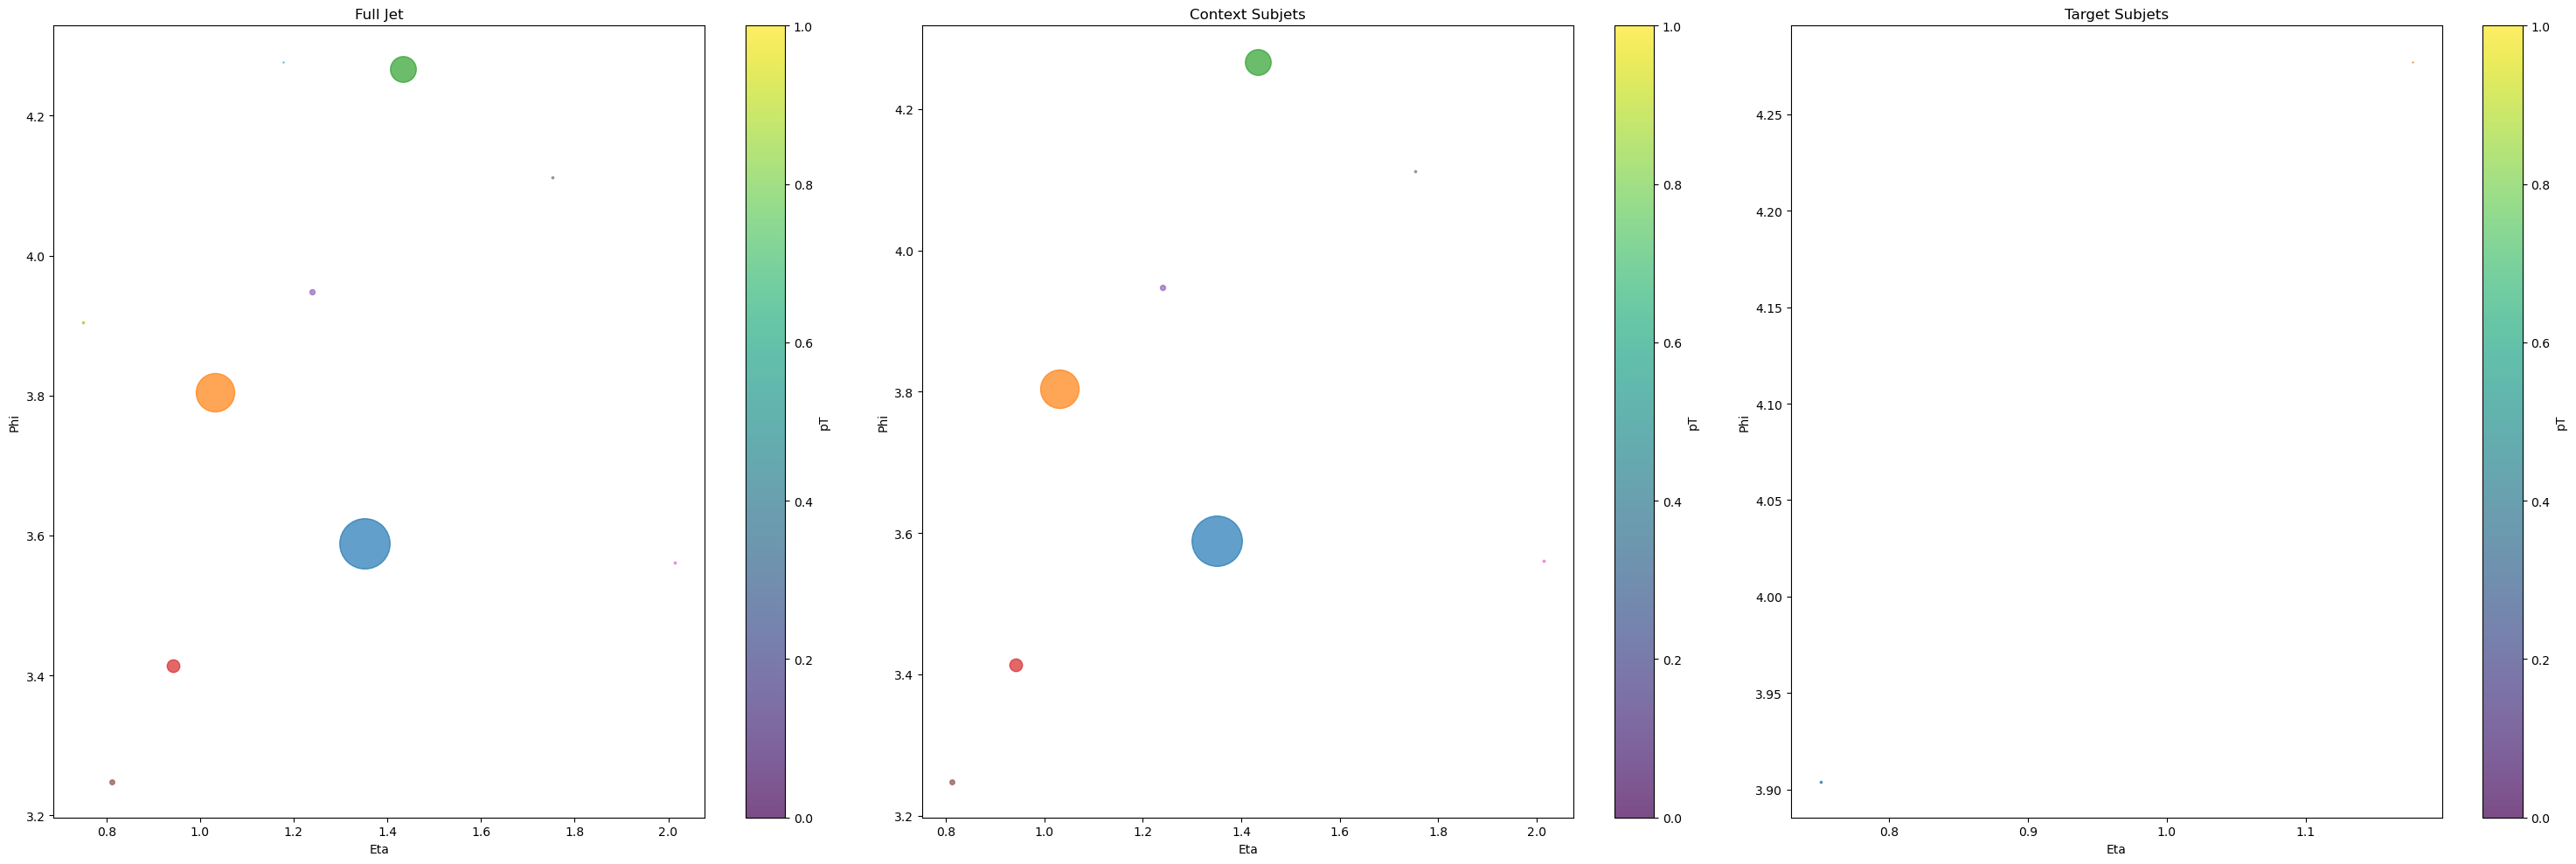

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

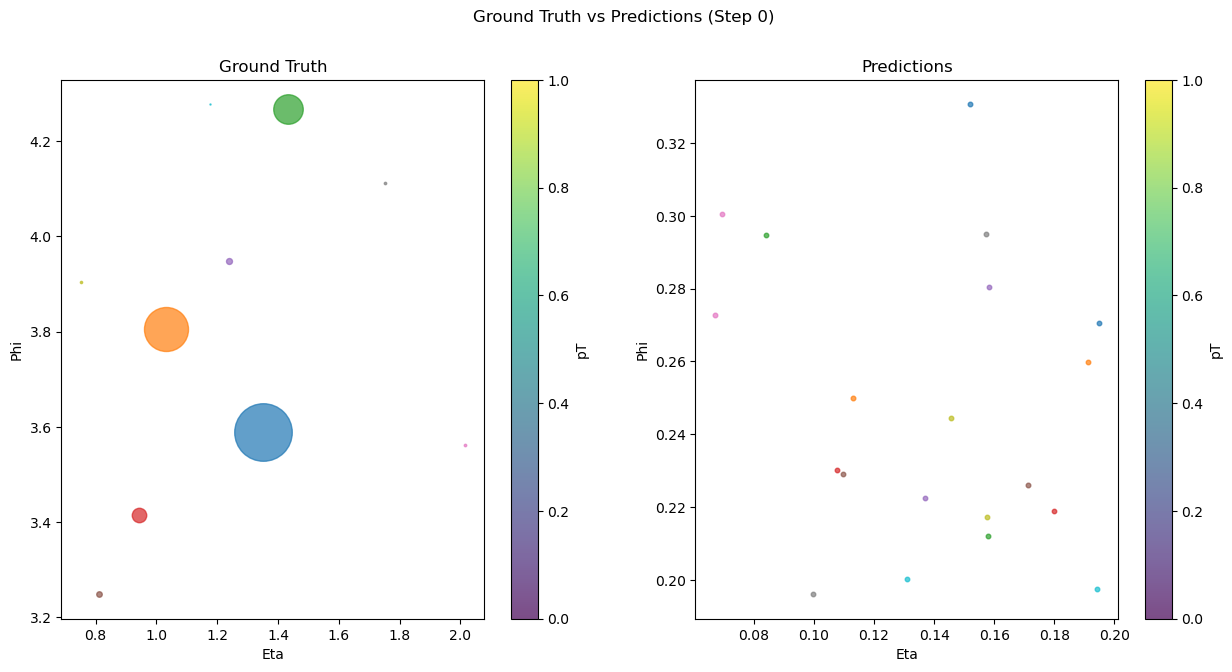

Epoch 2/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:01<00:24,  1.23it/s, loss=296]

Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])

Epoch 2, Step 0, Loss: 291.7853
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 2/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:09,  2.89it/s, loss=321]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 368.8231201171875
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 2/10:  19%|█████████████████████████████▎                                                                                                                              | 6/32 [00:02<00:05,  4.67it/s, loss=356]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.

Epoch 2/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.47it/s, loss=350]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step

Epoch 2/10:  28%|███████████████████████████████████████████▉                                                                                                                | 9/32 [00:02<00:03,  6.71it/s, loss=428]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 2/10:  34%|█████████████████████████████████████████████████████▎                                                                                                     | 11/32 [00:02<00:02,  7.53it/s, loss=423]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 282.73724365234375
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.

Epoch 2/10:  41%|██████████████████████████████████████████████████████████████▉                                                                                            | 13/32 [00:03<00:02,  7.94it/s, loss=489]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 11
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.S

Epoch 2/10:  44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 14/32 [00:03<00:02,  8.08it/s, loss=290]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 13
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random ma

Epoch 2/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:01,  8.24it/s, loss=485]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([24, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 2/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:03<00:01,  8.36it/s, loss=347]

Applying target encoder
Context encoder output shape: torch.Size([32, 21, 384])
Target encoder output shape: torch.Size([32, 21, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 21, 240])
Final predicted representation shape: torch.Size([32, 21, 8, 30])
Final target representation shape: torch.Size([32, 21, 8, 30])
Predicted representation shape: torch.Size([32, 21, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 21, 384])
Target representation shape: torch.Size([32, 21, 8, 30])
Combined mask shape: torch.Size([32, 21, 8, 30])
Calculated loss: 301.38665771484375
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 2/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20/32 [00:04<00:01,  8.40it/s, loss=342]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 18
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped contex

Epoch 2/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  8.42it/s, loss=271]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step

Epoch 2/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  8.46it/s, loss=341]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 2/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 25/32 [00:04<00:00,  8.39it/s, loss=451]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 224.5124053955078
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 2/10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 27/32 [00:04<00:00,  8.40it/s, loss=218]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 25
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.

Epoch 2/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28/32 [00:05<00:00,  8.41it/s, loss=530]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 27
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch

Epoch 2/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 30/32 [00:05<00:00,  8.44it/s, loss=403]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.89it/s, loss=382]


Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 377.8346862792969
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Startin

Epoch 3/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

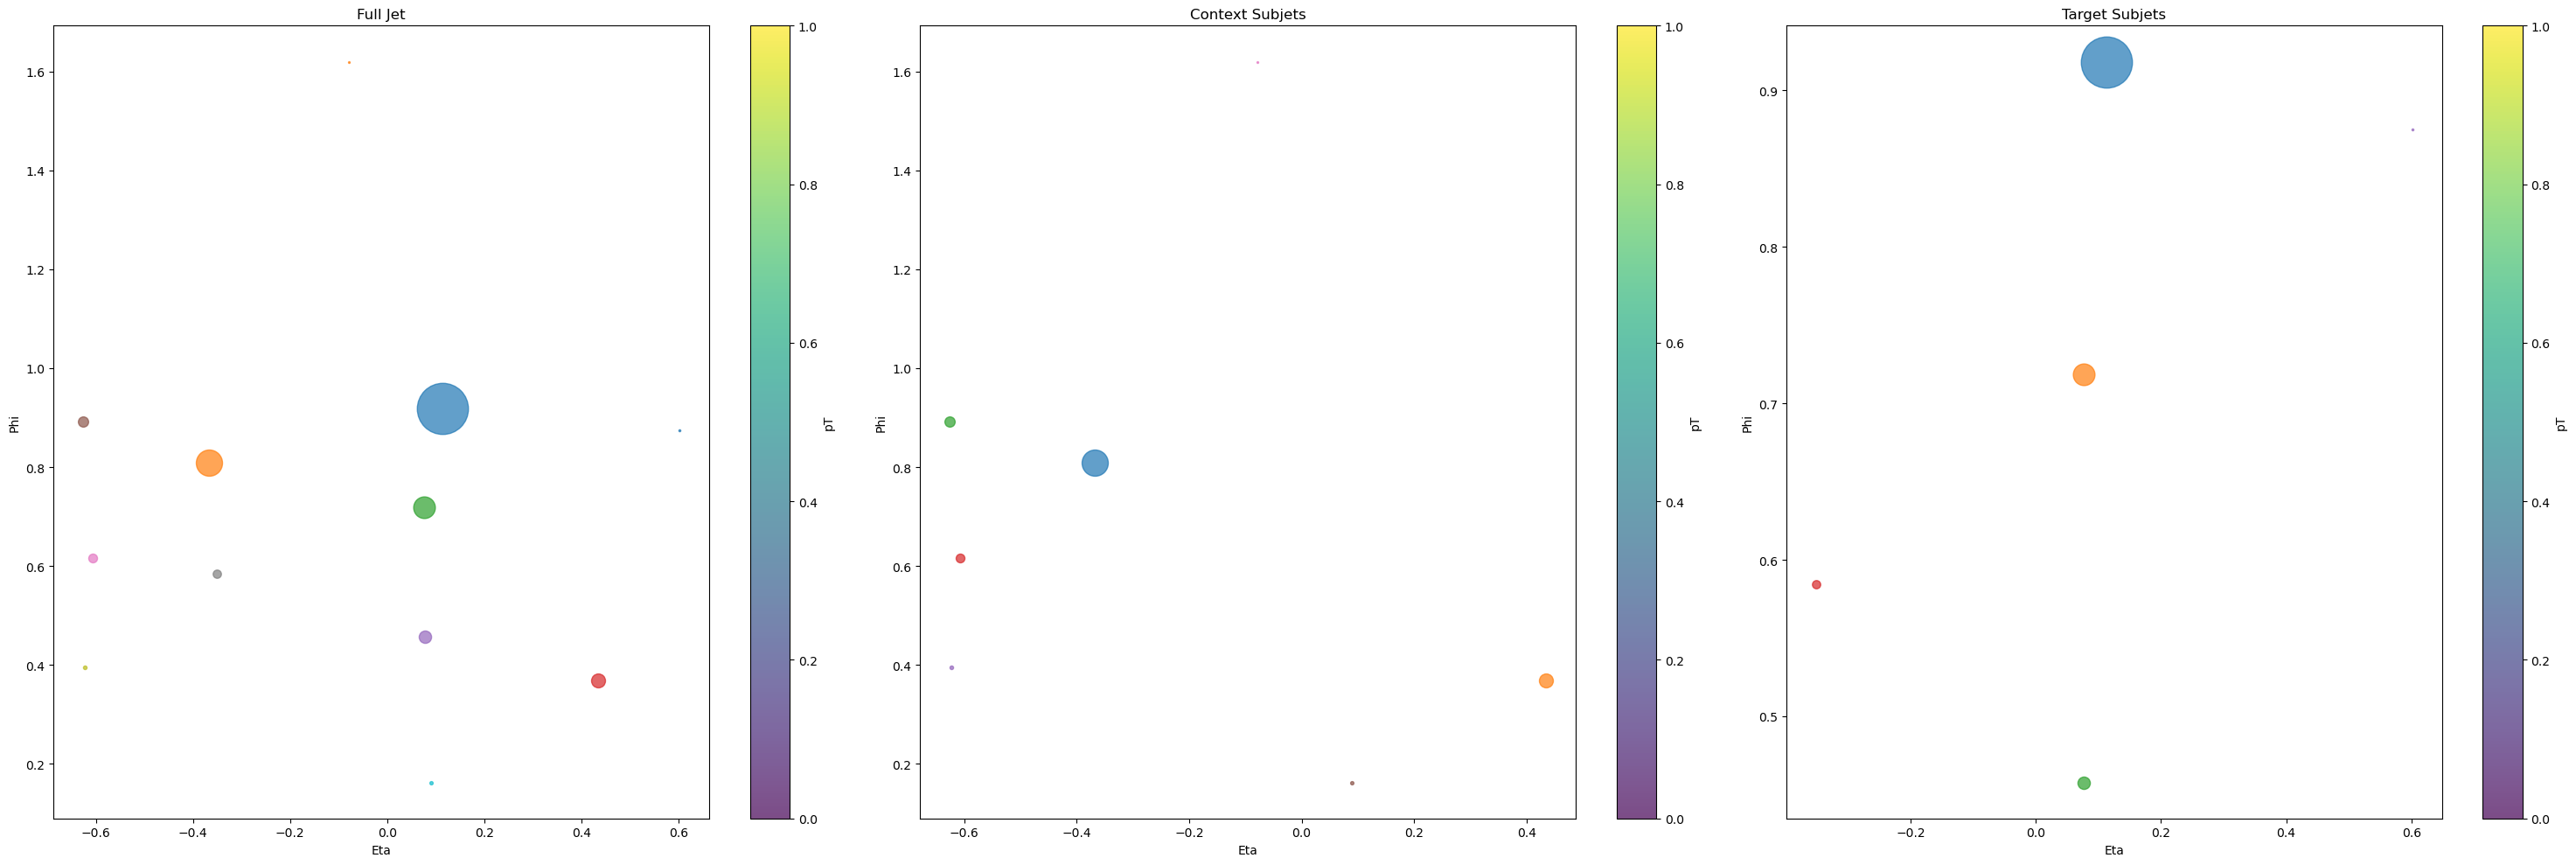

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

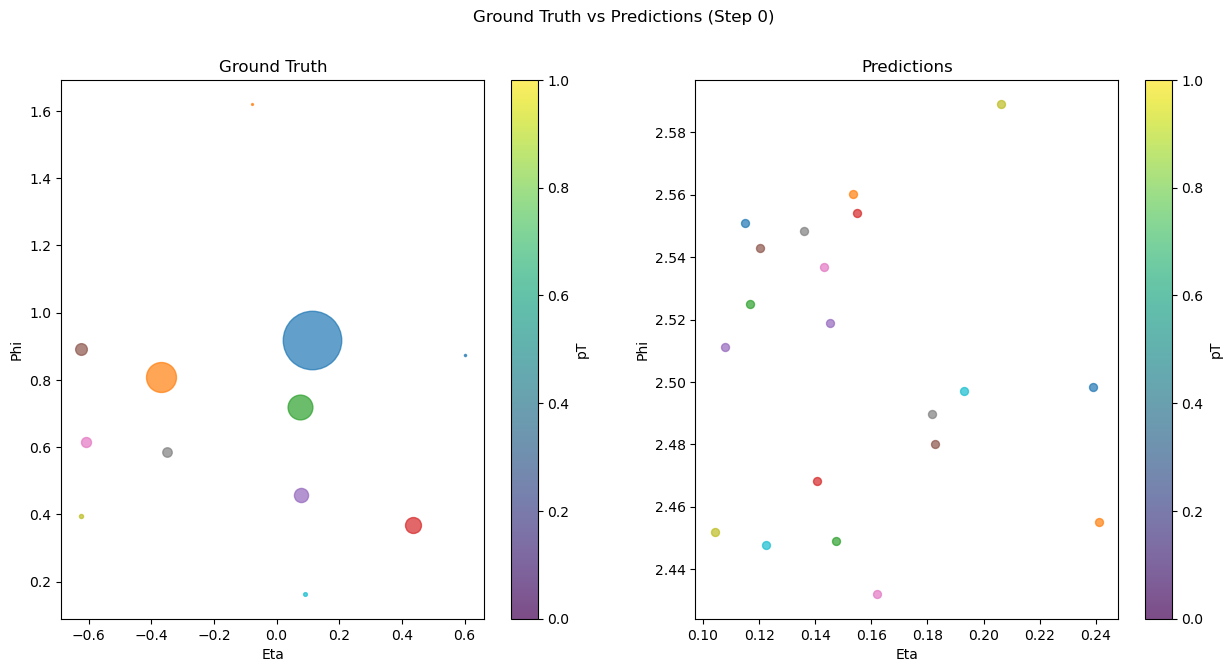

Epoch 3/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:02<00:25,  1.17it/s, loss=498]

Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])

Epoch 3, Step 0, Loss: 175.8216
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 3/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:10,  2.78it/s, loss=435]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 300.9396667480469
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 3/10:  19%|█████████████████████████████▎                                                                                                                              | 6/32 [00:02<00:05,  4.54it/s, loss=402]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context

Epoch 3/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.36it/s, loss=337]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 6
Input shapes - Subjets: torch.Size(

Epoch 3/10:  28%|███████████████████████████████████████████▉                                                                                                                | 9/32 [00:02<00:03,  6.66it/s, loss=535]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 3/10:  34%|█████████████████████████████████████████████████████▎                                                                                                     | 11/32 [00:03<00:02,  7.45it/s, loss=562]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 204.28253173828125
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 3/10:  41%|██████████████████████████████████████████████████████████████▉                                                                                            | 13/32 [00:03<00:02,  7.88it/s, loss=418]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 11
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32,

Epoch 3/10:  44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 14/32 [00:03<00:02,  8.04it/s, loss=194]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([22, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 3/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:01,  8.16it/s, loss=425]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 310.6816101074219
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 3/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:03<00:01,  8.29it/s, loss=261]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 16
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.

Epoch 3/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 19/32 [00:04<00:01,  8.33it/s, loss=233]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([23, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 18
Input shapes - Subjets: torch.Size([32, 23, 8, 30]), Subjet masks: torch.Size([32, 23]), Particle masks: torch

Epoch 3/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  8.40it/s, loss=363]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 3/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  8.40it/s, loss=231]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 263.98760986328125
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 3/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 25/32 [00:04<00:00,  8.41it/s, loss=422]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([24, 8, 30])
Starting custom_collate_fn

Starting training step 23
Input shapes - Subjets: torch.Size([32, 24, 8, 30]), Subjet masks: torch.Size([32, 24]), Particle masks: torch.Size([32, 24, 30])
Creating random masks with batch_size=32, num_subjets=24
Sample context mask shape: torch.Size([24, 8, 30])
Sample target mask shape: torch.Size([24, 8, 30])
Mask shapes - Context: torch.Size([32, 24, 8, 30]), Target: torch.Size([32, 24, 8, 30])
Context subjets shape: torch.Size([32, 24, 8, 30])
Target subjets shape: torch.Size([32, 24, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 24, 8, 30])
Input target shape: torch

Epoch 3/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 26/32 [00:04<00:00,  8.42it/s, loss=388]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting cus

Epoch 3/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28/32 [00:05<00:00,  8.42it/s, loss=349]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 3/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 30/32 [00:05<00:00,  8.44it/s, loss=301]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 163.28912353515625
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.78it/s, loss=450]


subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 30
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch

Epoch 4/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

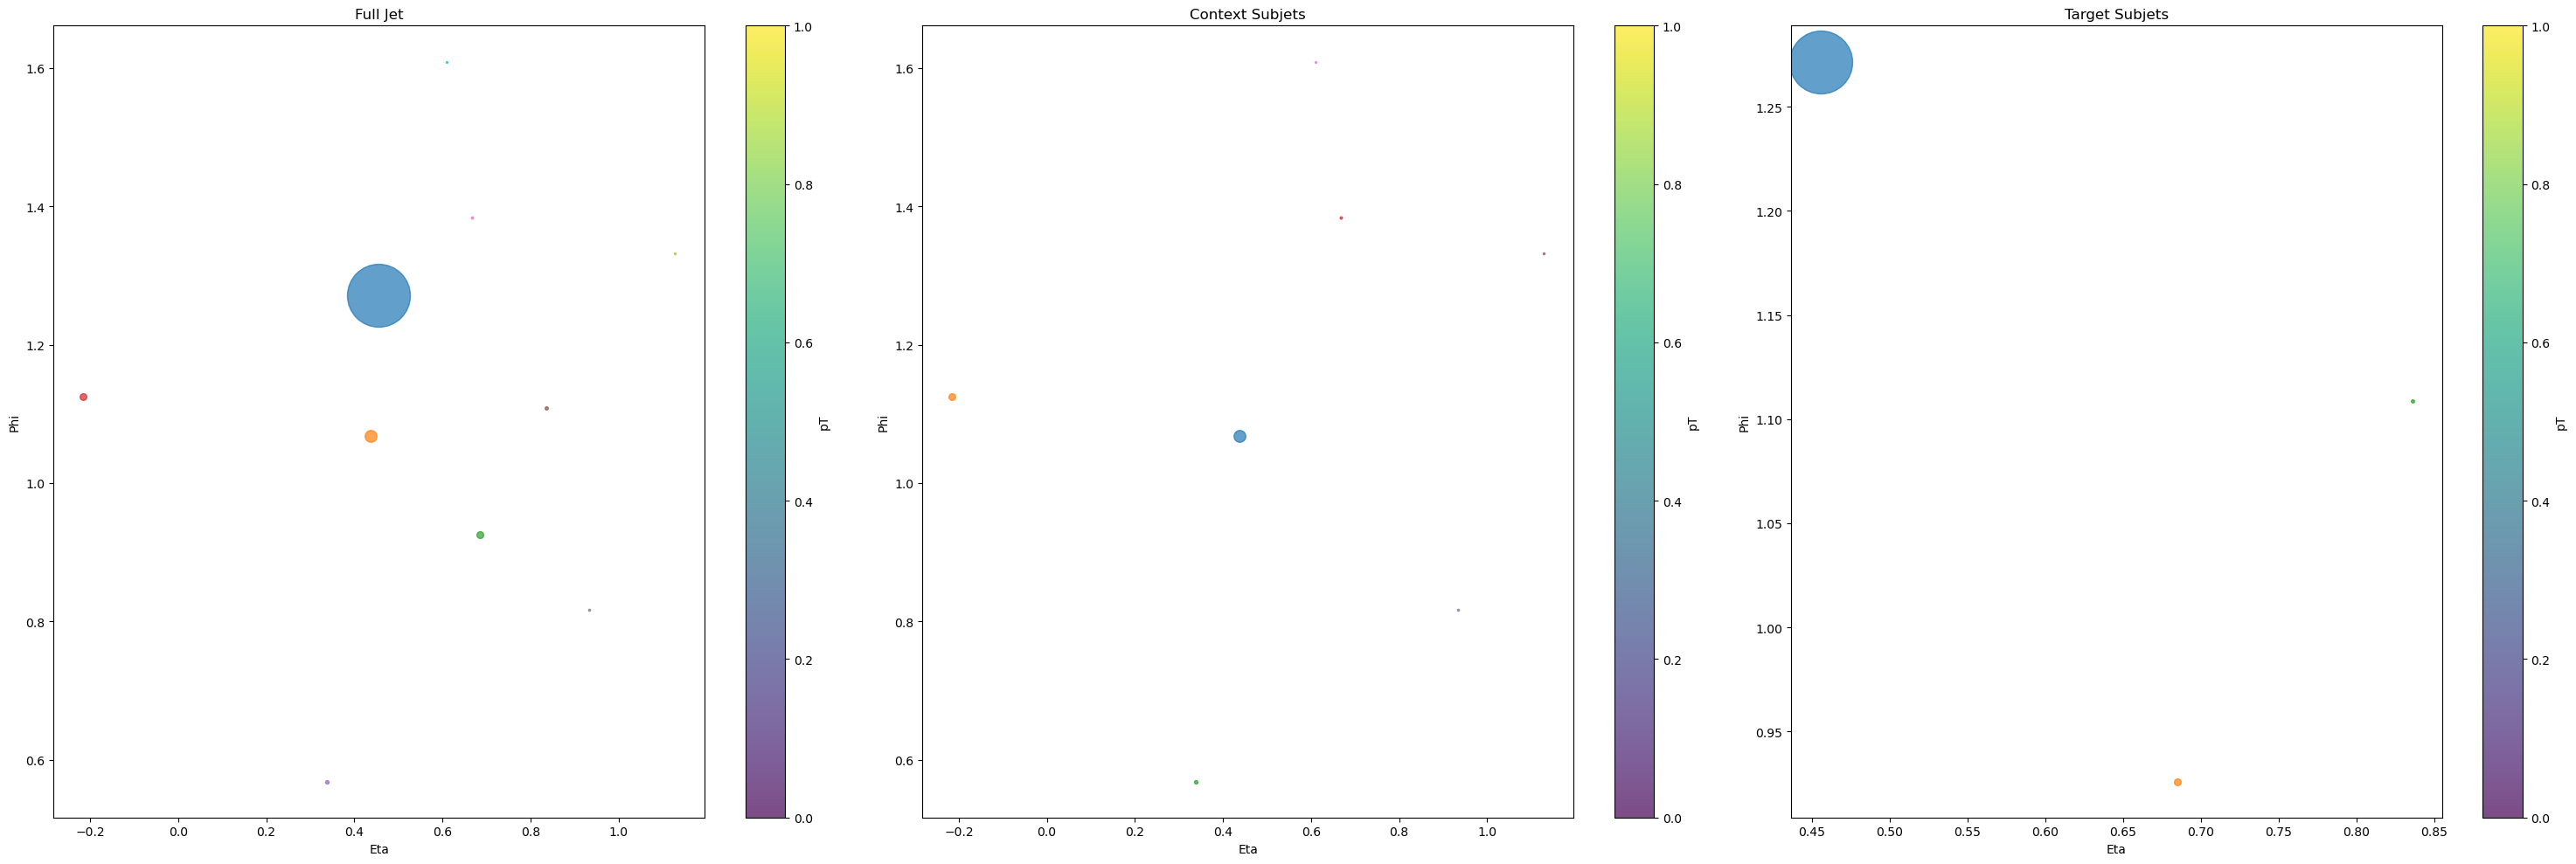

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

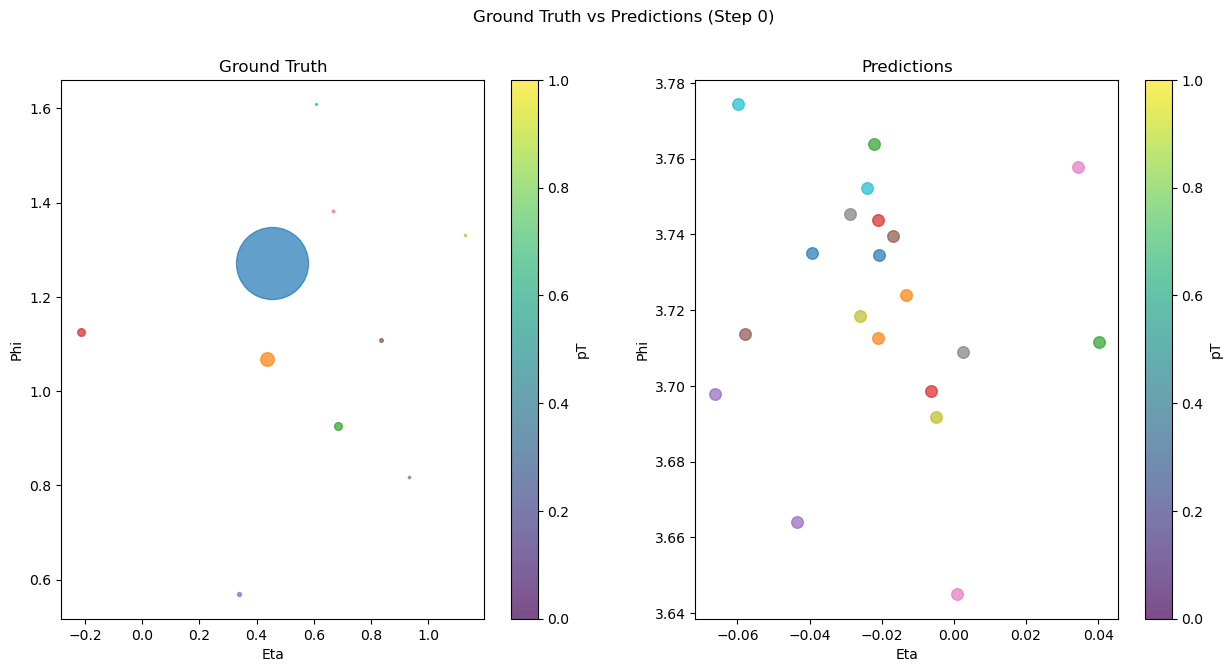

Epoch 4/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:01<00:24,  1.22it/s, loss=464]

Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])

Epoch 4, Step 0, Loss: 324.6400
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 4/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:09,  2.83it/s, loss=412]

Applying target encoder
Context encoder output shape: torch.Size([32, 21, 384])
Target encoder output shape: torch.Size([32, 21, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 21, 240])
Final predicted representation shape: torch.Size([32, 21, 8, 30])
Final target representation shape: torch.Size([32, 21, 8, 30])
Predicted representation shape: torch.Size([32, 21, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 21, 384])
Target representation shape: torch.Size([32, 21, 8, 30])
Combined mask shape: torch.Size([32, 21, 8, 30])
Calculated loss: 480.21905517578125
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 4/10:  19%|█████████████████████████████▎                                                                                                                              | 6/32 [00:02<00:05,  4.60it/s, loss=177]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torc

Epoch 4/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.40it/s, loss=492]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 4/10:  28%|███████████████████████████████████████████▉                                                                                                                | 9/32 [00:02<00:03,  6.65it/s, loss=362]

Applying target encoder
Context encoder output shape: torch.Size([32, 24, 384])
Target encoder output shape: torch.Size([32, 24, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 24, 240])
Final predicted representation shape: torch.Size([32, 24, 8, 30])
Final target representation shape: torch.Size([32, 24, 8, 30])
Predicted representation shape: torch.Size([32, 24, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 24, 384])
Target representation shape: torch.Size([32, 24, 8, 30])
Combined mask shape: torch.Size([32, 24, 8, 30])
Calculated loss: 179.78802490234375
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 4/10:  34%|█████████████████████████████████████████████████████▎                                                                                                     | 11/32 [00:03<00:02,  7.42it/s, loss=370]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 9
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.

Epoch 4/10:  38%|██████████████████████████████████████████████████████████▏                                                                                                | 12/32 [00:03<00:02,  7.69it/s, loss=397]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 4/10:  44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 14/32 [00:03<00:02,  7.95it/s, loss=504]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 220.63848876953125
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.

Epoch 4/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:01,  8.21it/s, loss=236]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 14
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.

Epoch 4/10:  53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17/32 [00:03<00:01,  8.14it/s, loss=449]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 16
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch

Epoch 4/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 19/32 [00:03<00:01,  8.27it/s, loss=245]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 4/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  8.28it/s, loss=398]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 348.6387023925781
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 4/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  8.33it/s, loss=282]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 21
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32,

Epoch 4/10:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 24/32 [00:04<00:00,  8.31it/s, loss=423]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 4/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 26/32 [00:04<00:00,  8.32it/s, loss=259]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 206.94140625
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([

Epoch 4/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28/32 [00:05<00:00,  8.34it/s, loss=374]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 26
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.

Epoch 4/10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 29/32 [00:05<00:00,  8.31it/s, loss=166]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([23, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 28
Input shapes - Subjets: torch.Size([32, 23, 8, 30]), Subjet masks: torch

Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.82it/s, loss=385]


subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 5/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([21, 8, 30])
subjets shap

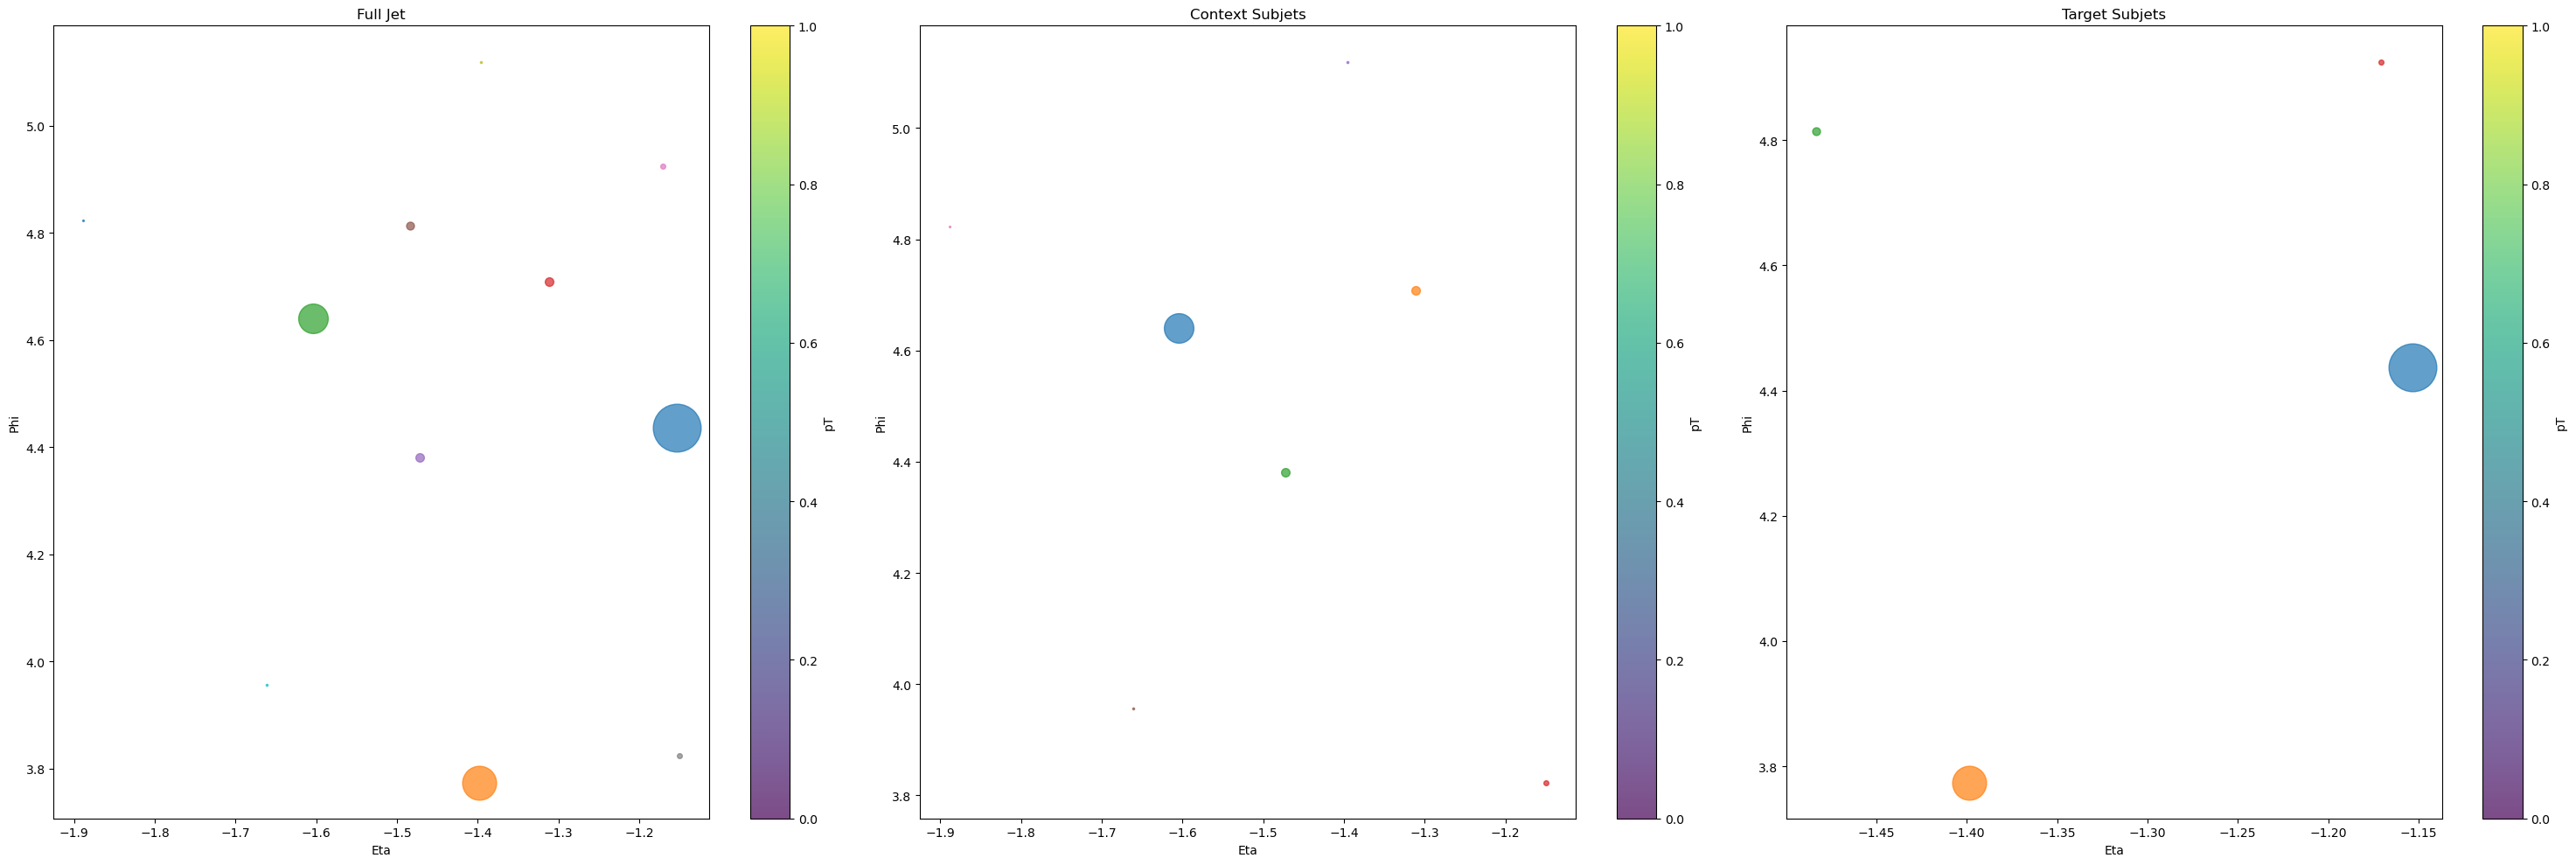

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 21, 8, 30])
Input target shape: torch.Size([32, 21, 8, 30])
Reshaped context shape: torch.Size([32, 21, 240])
Reshaped target shape: torch.Size([32, 21, 240])
Embedded context shape: torch.Size([32, 21, 384])
Embedded target shape: torch.Size([32, 21, 384])
torch.Size([32, 21, 384]) torch.Size([32, 21, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 21, 384])
Target encoder output shape: torch.Size([32, 21, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 21, 240])
Final predicted representation shape: torch.Size([32, 21, 8, 30])
Final target representation shape: torch.Size([32, 21, 8, 30])
Predicted representation shape: torch.Size([32, 21, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 21, 384])
Target representation shape: torch.Size([32, 21, 8, 30]

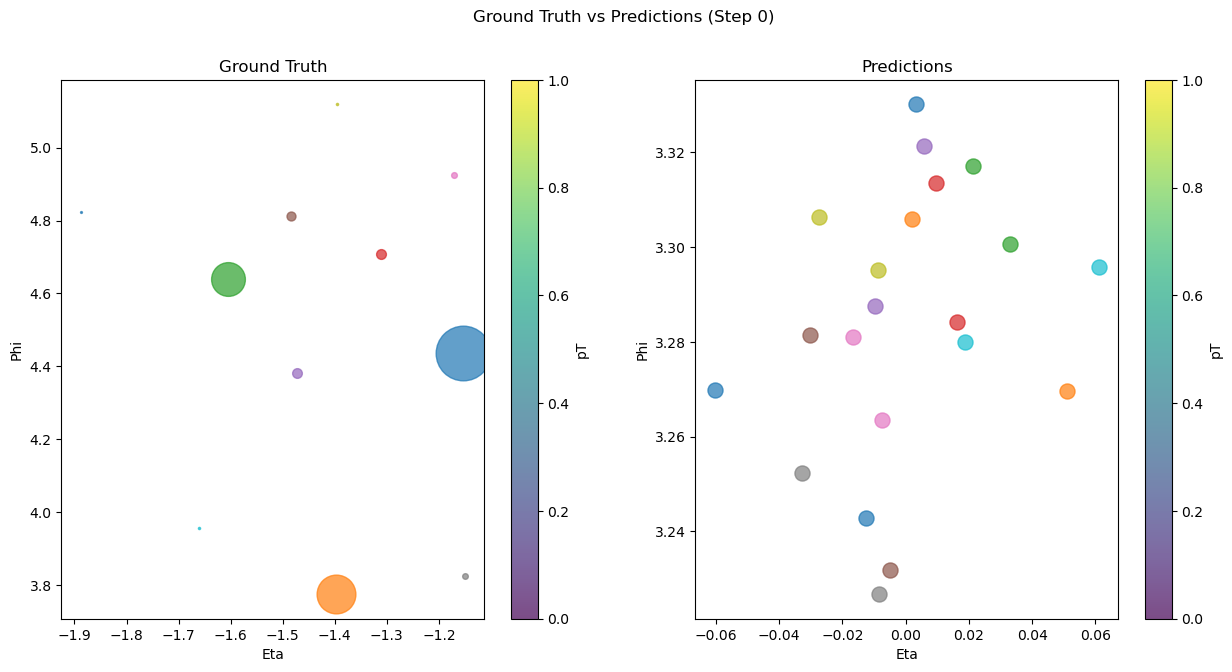

Epoch 5/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:02<00:25,  1.17it/s, loss=389]

Context representation shape: torch.Size([32, 21, 384])
Target representation shape: torch.Size([32, 21, 8, 30])

Epoch 5, Step 0, Loss: 323.0520
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 5/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:10,  2.71it/s, loss=399]

Starting custom_collate_fn

Starting training step 2
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder outpu

Epoch 5/10:  16%|████████████████████████▍                                                                                                                                   | 5/32 [00:02<00:07,  3.54it/s, loss=319]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 5/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.07it/s, loss=274]

Applying target encoder
Context encoder output shape: torch.Size([32, 23, 384])
Target encoder output shape: torch.Size([32, 23, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 23, 240])
Final predicted representation shape: torch.Size([32, 23, 8, 30])
Final target representation shape: torch.Size([32, 23, 8, 30])
Predicted representation shape: torch.Size([32, 23, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 23, 384])
Target representation shape: torch.Size([32, 23, 8, 30])
Combined mask shape: torch.Size([32, 23, 8, 30])
Calculated loss: 274.8228454589844
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 5/10:  25%|███████████████████████████████████████                                                                                                                     | 8/32 [00:02<00:04,  5.70it/s, loss=359]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 7
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape:

Epoch 5/10:  31%|████████████████████████████████████████████████▍                                                                                                          | 10/32 [00:03<00:03,  6.62it/s, loss=347]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 5/10:  38%|██████████████████████████████████████████████████████████▏                                                                                                | 12/32 [00:03<00:02,  7.13it/s, loss=265]

Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: to

Epoch 5/10:  41%|██████████████████████████████████████████████████████████████▉                                                                                            | 13/32 [00:03<00:02,  7.29it/s, loss=506]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting cus

Epoch 5/10:  47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 15/32 [00:03<00:02,  7.49it/s, loss=376]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 222.83547973632812
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.

Epoch 5/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:02,  7.55it/s, loss=418]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 15
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])


Epoch 5/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:04<00:01,  7.62it/s, loss=428]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 5/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20/32 [00:04<00:01,  7.62it/s, loss=462]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 294.6471862792969
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 5/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  7.63it/s, loss=257]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 20
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20

Epoch 5/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  7.63it/s, loss=136]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 242.90304565429688
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.

Epoch 5/10:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 24/32 [00:04<00:01,  7.66it/s, loss=155]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 23
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32,

Epoch 5/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 26/32 [00:05<00:00,  7.72it/s, loss=177]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([22, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 5/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28/32 [00:05<00:00,  7.68it/s, loss=328]

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

Epoch 5/10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 29/32 [00:05<00:00,  7.66it/s, loss=447]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting cus

Epoch 5/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 31/32 [00:05<00:00,  7.60it/s, loss=200]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 408.31402587890625
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s, loss=65.3]


Applying target encoder
Context encoder output shape: torch.Size([8, 20, 384])
Target encoder output shape: torch.Size([8, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([8, 20, 240])
Final predicted representation shape: torch.Size([8, 20, 8, 30])
Final target representation shape: torch.Size([8, 20, 8, 30])
Predicted representation shape: torch.Size([8, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([8, 20, 384])
Target representation shape: torch.Size([8, 20, 8, 30])
Combined mask shape: torch.Size([8, 20, 8, 30])
Calculated loss: 65.26148986816406
Epoch 5/10, Training Loss: 320.5632


Epoch 6/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

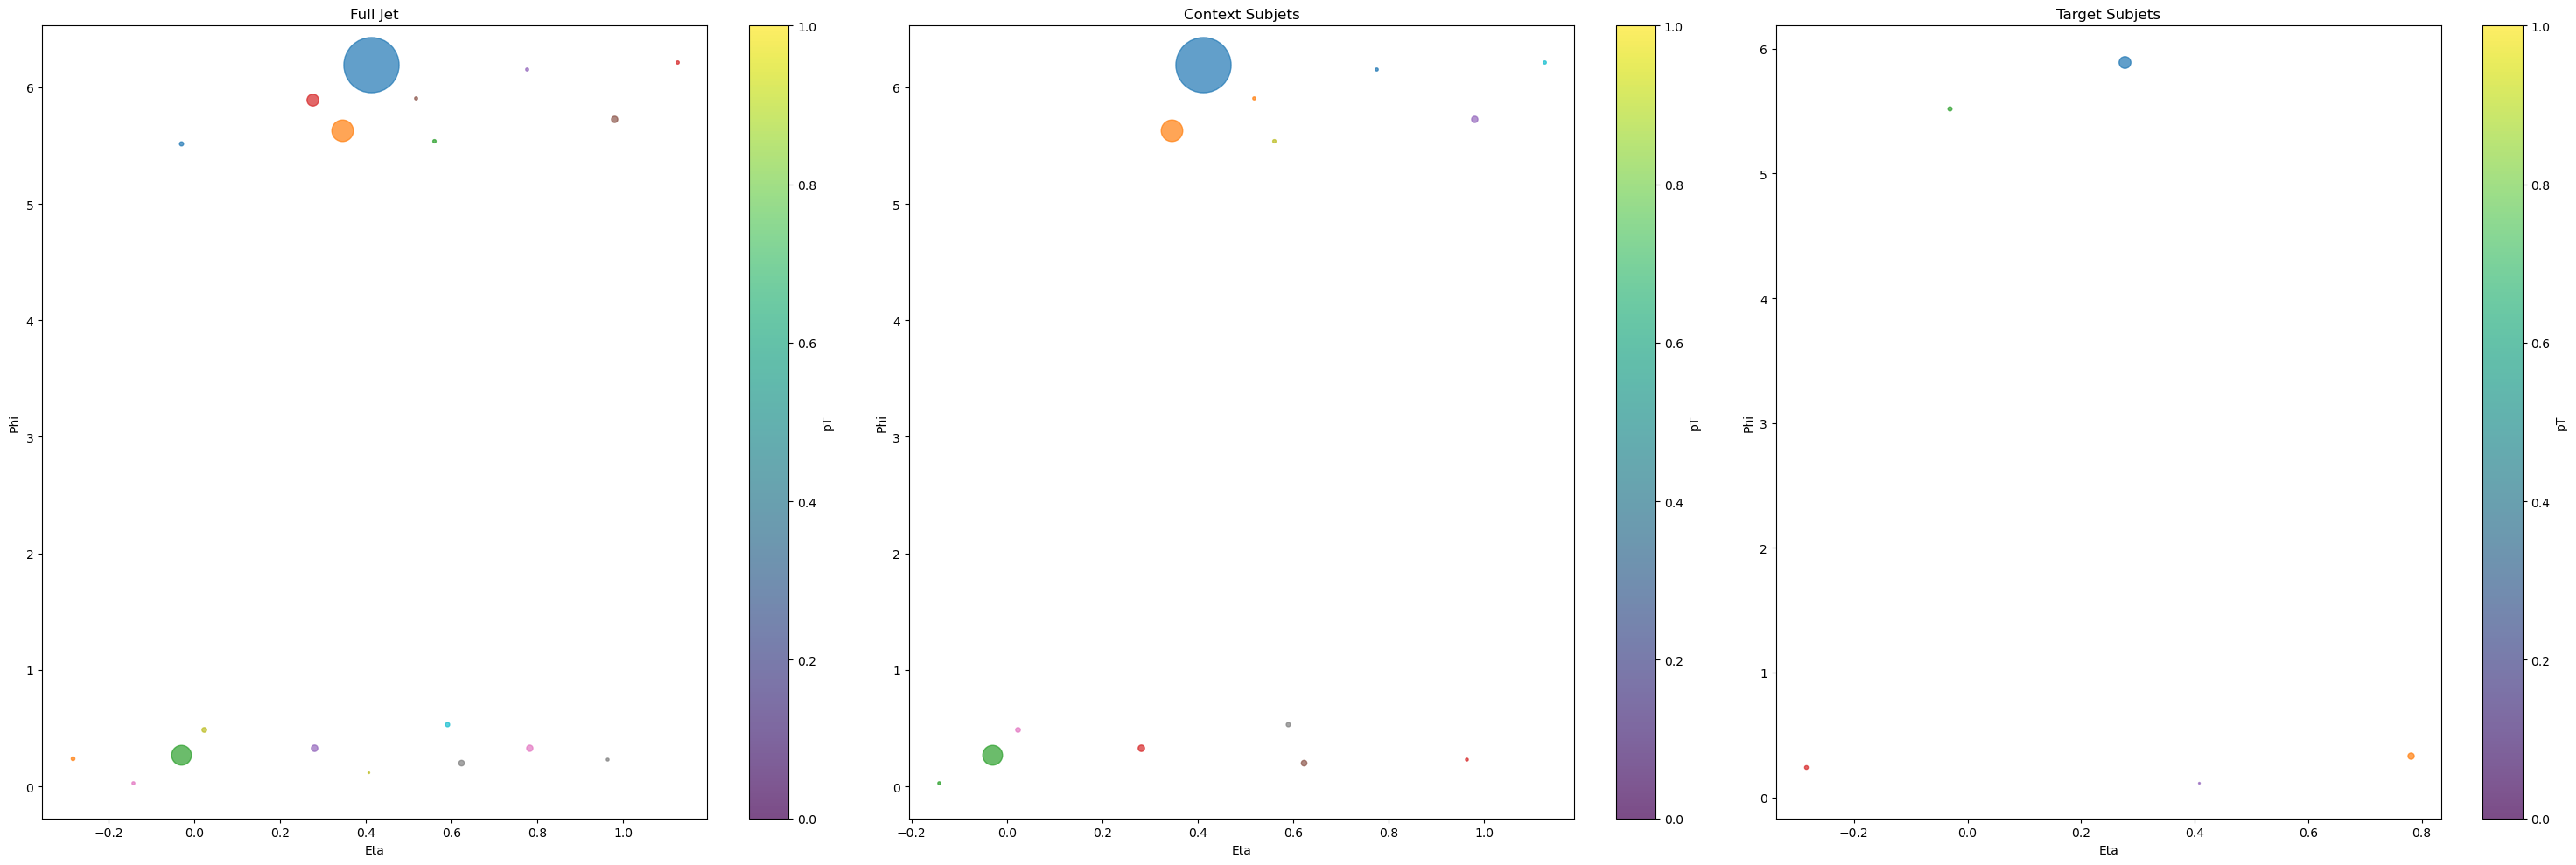

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

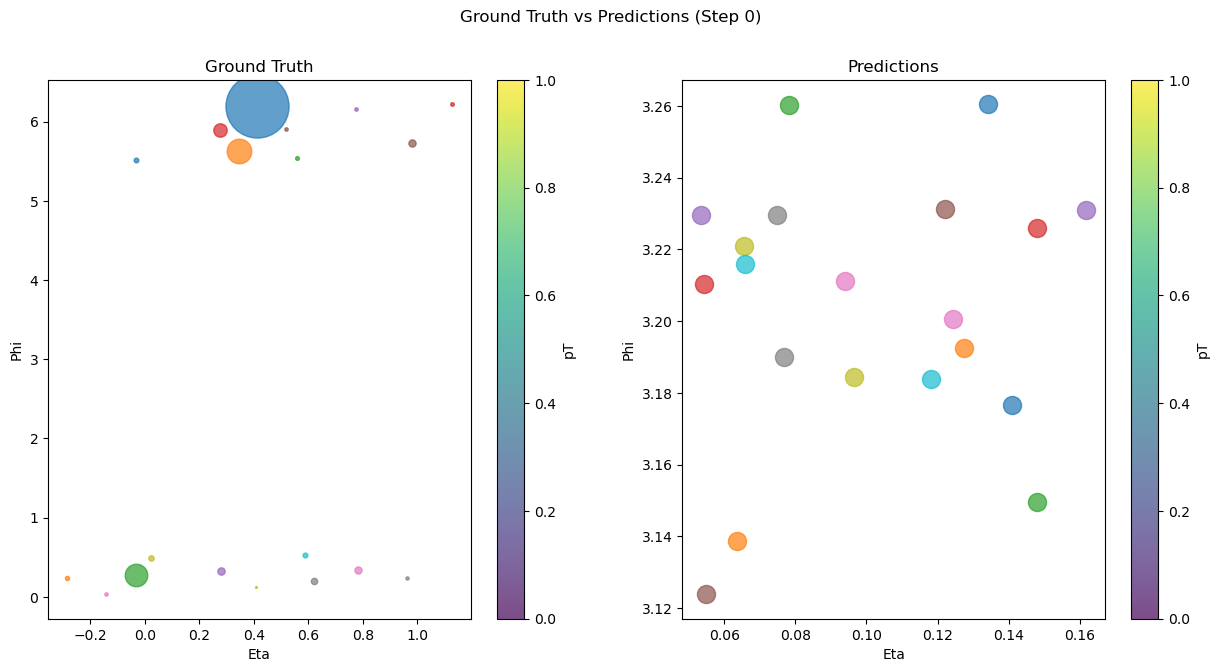

Epoch 6/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:02<00:28,  1.06it/s, loss=282]

Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])

Epoch 6, Step 0, Loss: 336.7902
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([24, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 6/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:11,  2.52it/s, loss=283]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 2
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 

Epoch 6/10:  16%|████████████████████████▍                                                                                                                                   | 5/32 [00:02<00:08,  3.33it/s, loss=351]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 6/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:05,  4.88it/s, loss=423]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 317.78173828125
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])

Epoch 6/10:  25%|███████████████████████████████████████                                                                                                                     | 8/32 [00:02<00:04,  5.54it/s, loss=307]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([21, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([22, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 7
Input shapes - Subjets: torch.Size([32, 22, 8, 30]), Subjet masks: torch.Size([32, 22]), Particle masks: torch.Size([32, 22, 30])
Creating random masks with batch_size=32, num_subjets=22
Sample context mask shape: torch.Size([22, 8, 30])
Sample target mask shape:

Epoch 6/10:  31%|████████████████████████████████████████████████▍                                                                                                          | 10/32 [00:03<00:03,  6.54it/s, loss=408]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 6/10:  38%|██████████████████████████████████████████████████████████▏                                                                                                | 12/32 [00:03<00:02,  7.11it/s, loss=275]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 156.4263916015625
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 6/10:  41%|██████████████████████████████████████████████████████████████▉                                                                                            | 13/32 [00:03<00:02,  7.30it/s, loss=441]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 12
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size

Epoch 6/10:  47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 15/32 [00:03<00:02,  7.50it/s, loss=489]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 6/10:  53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17/32 [00:04<00:01,  7.61it/s, loss=233]

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

Epoch 6/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:04<00:01,  7.66it/s, loss=419]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step

Epoch 6/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20/32 [00:04<00:01,  7.45it/s, loss=193]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 226.81524658203125
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 6/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  7.47it/s, loss=447]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 20
Input shapes - Subjets: torch.Size

Epoch 6/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  7.55it/s, loss=430]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 196.3986053466797
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 6/10:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 24/32 [00:05<00:01,  7.60it/s, loss=438]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 23
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])


Epoch 6/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 26/32 [00:05<00:00,  7.69it/s, loss=311]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 6/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28/32 [00:05<00:00,  7.77it/s, loss=342]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 350.73095703125
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])

Epoch 6/10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 29/32 [00:05<00:00,  7.81it/s, loss=187]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 28
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes 

Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.31it/s, loss=503]


subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 7/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

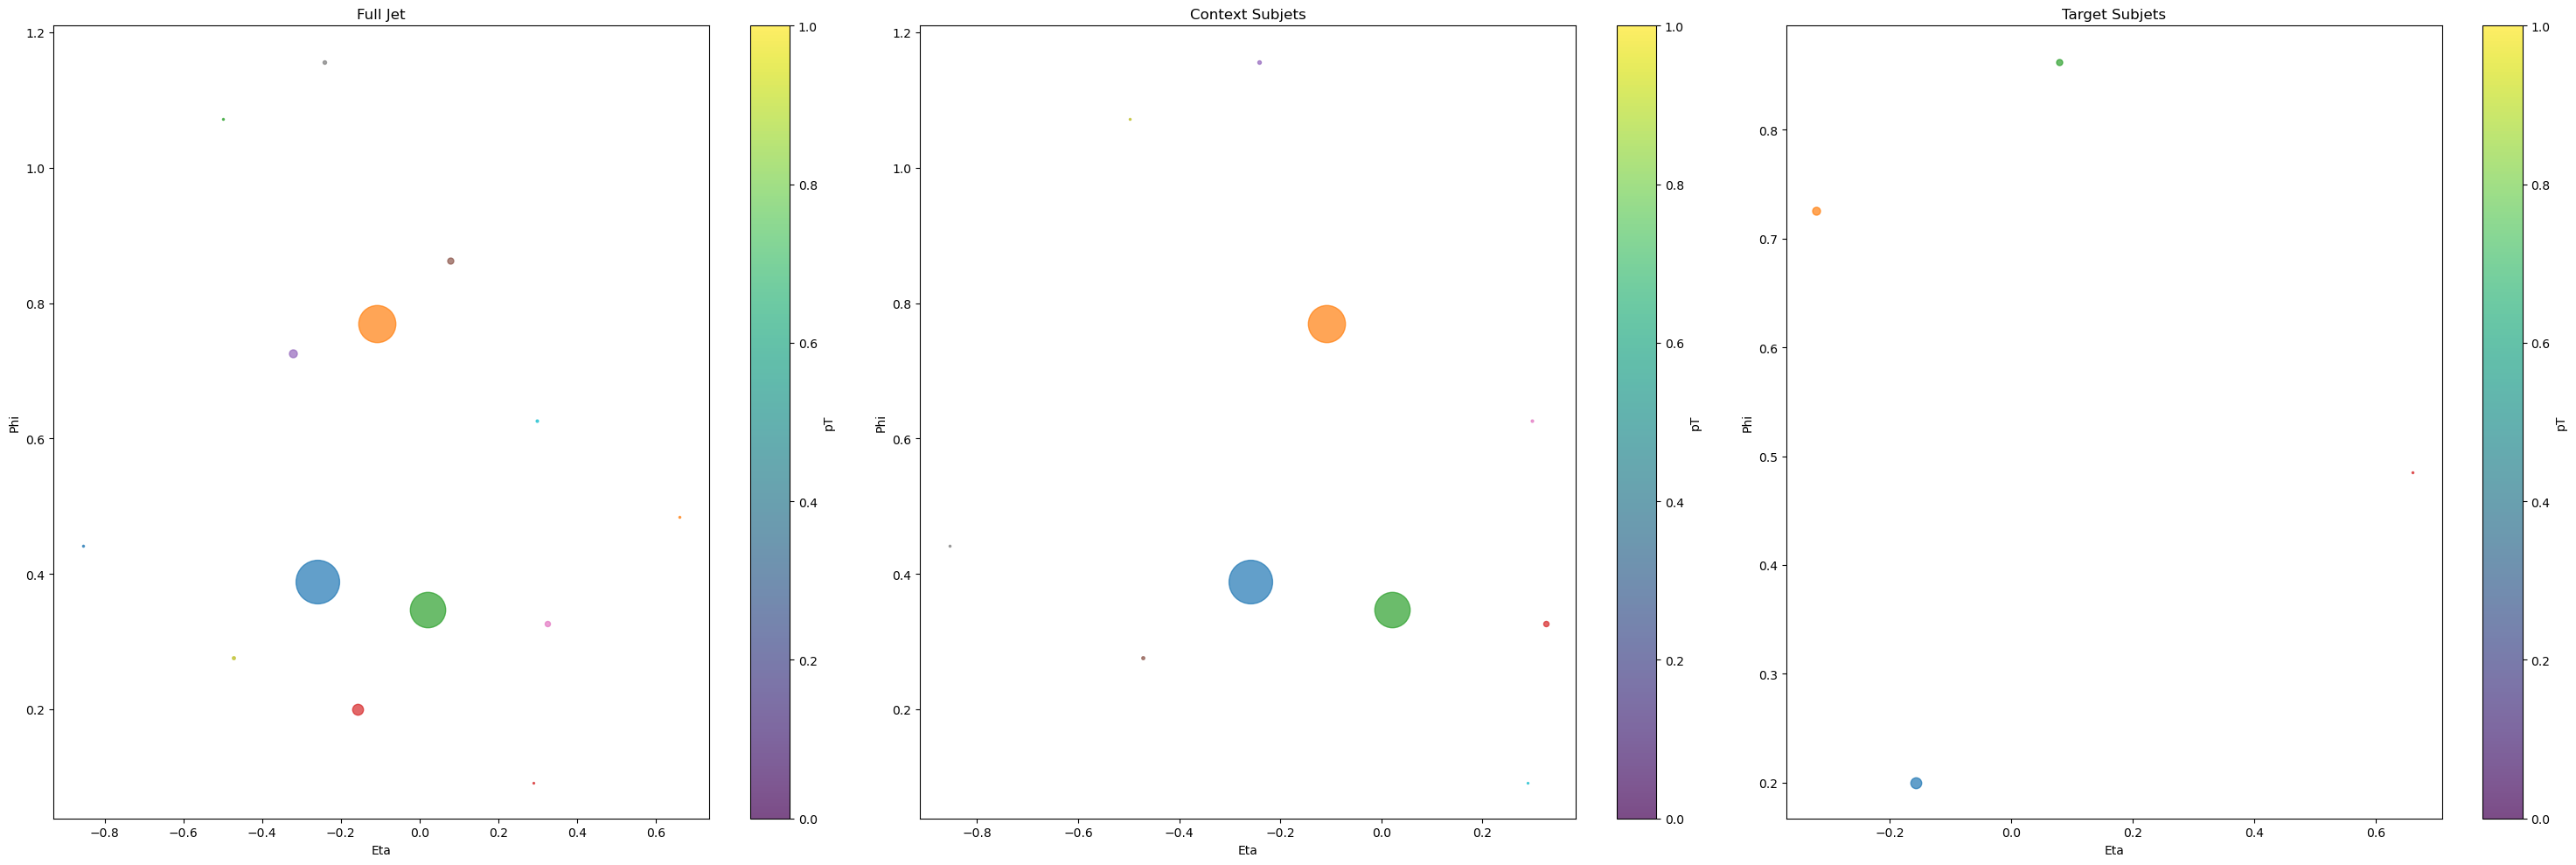

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

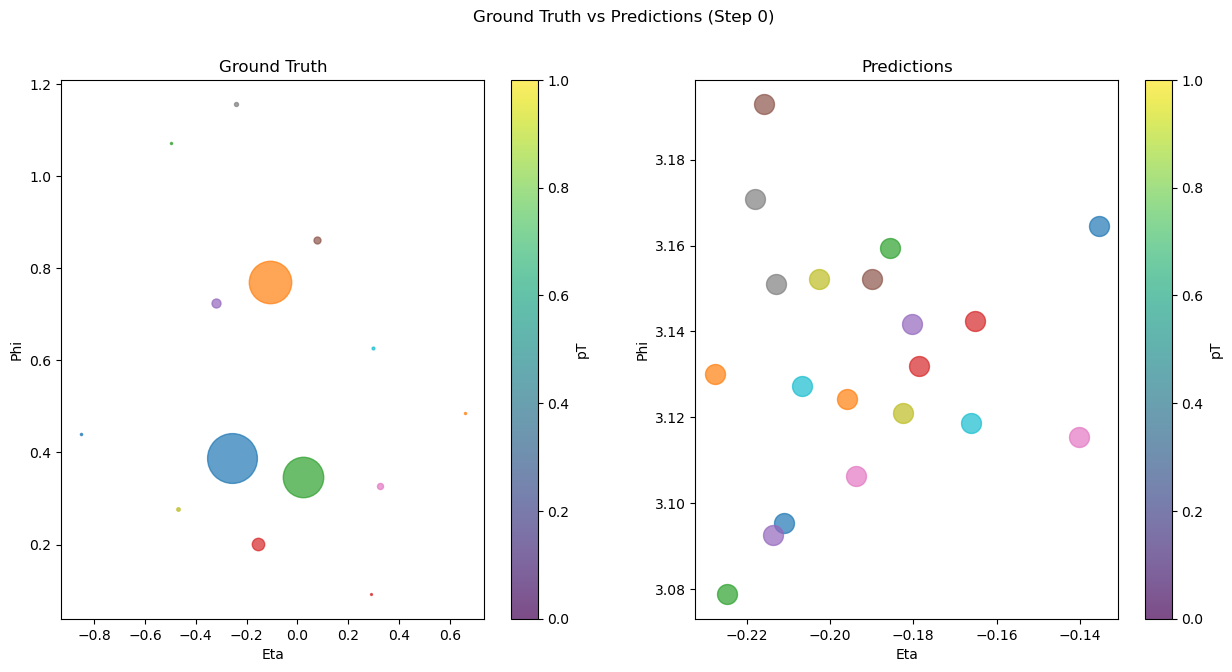

Epoch 7/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:02<00:25,  1.18it/s, loss=288]

Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])

Epoch 7, Step 0, Loss: 115.4451
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 7/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:10,  2.80it/s, loss=267]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 223.96255493164062
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 7/10:  19%|█████████████████████████████▎                                                                                                                              | 6/32 [00:02<00:05,  4.59it/s, loss=579]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20,

Epoch 7/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.42it/s, loss=339]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([22, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 6
Input shapes - Subjets: torch.Size([32, 22, 8, 30]), Subjet masks: torch.Size([32, 22]), Particle masks: torch.Size([32, 22, 30])
Creating random masks with batch_size=32, num_subjets=22


Epoch 7/10:  28%|███████████████████████████████████████████▉                                                                                                                | 9/32 [00:02<00:03,  6.77it/s, loss=181]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 7/10:  34%|█████████████████████████████████████████████████████▎                                                                                                     | 11/32 [00:03<00:02,  7.62it/s, loss=296]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 336.3766784667969
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 7/10:  41%|██████████████████████████████████████████████████████████████▉                                                                                            | 13/32 [00:03<00:02,  8.11it/s, loss=373]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 11
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 7/10:  47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 15/32 [00:03<00:02,  8.37it/s, loss=270]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 13
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes 

Epoch 7/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:01,  8.44it/s, loss=355]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 7/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:03<00:01,  8.44it/s, loss=442]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 284.2467346191406
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 7/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20/32 [00:04<00:01,  8.52it/s, loss=379]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 18
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.

Epoch 7/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  8.26it/s, loss=286]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 20
Input shapes - Subjets: torch.Size([32, 23, 8, 30]), Subjet masks: torch.Size([32, 23]), Particle masks: torch.Size([32, 23, 30])
Creating random masks with batch_size=32, num_subjets=23
Sample context mask shape: torch.Size

Epoch 7/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  8.45it/s, loss=437]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 25/32 [00:04<00:00,  8.56it/s, loss=366]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 385.0699462890625
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 7/10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 27/32 [00:04<00:00,  8.58it/s, loss=292]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 25
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 7/10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 29/32 [00:05<00:00,  8.62it/s, loss=425]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 27
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes 

Epoch 7/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 30/32 [00:05<00:00,  8.62it/s, loss=470]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.87it/s, loss=218]


Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 372.30023193359375
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 31
Inpu

Epoch 8/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

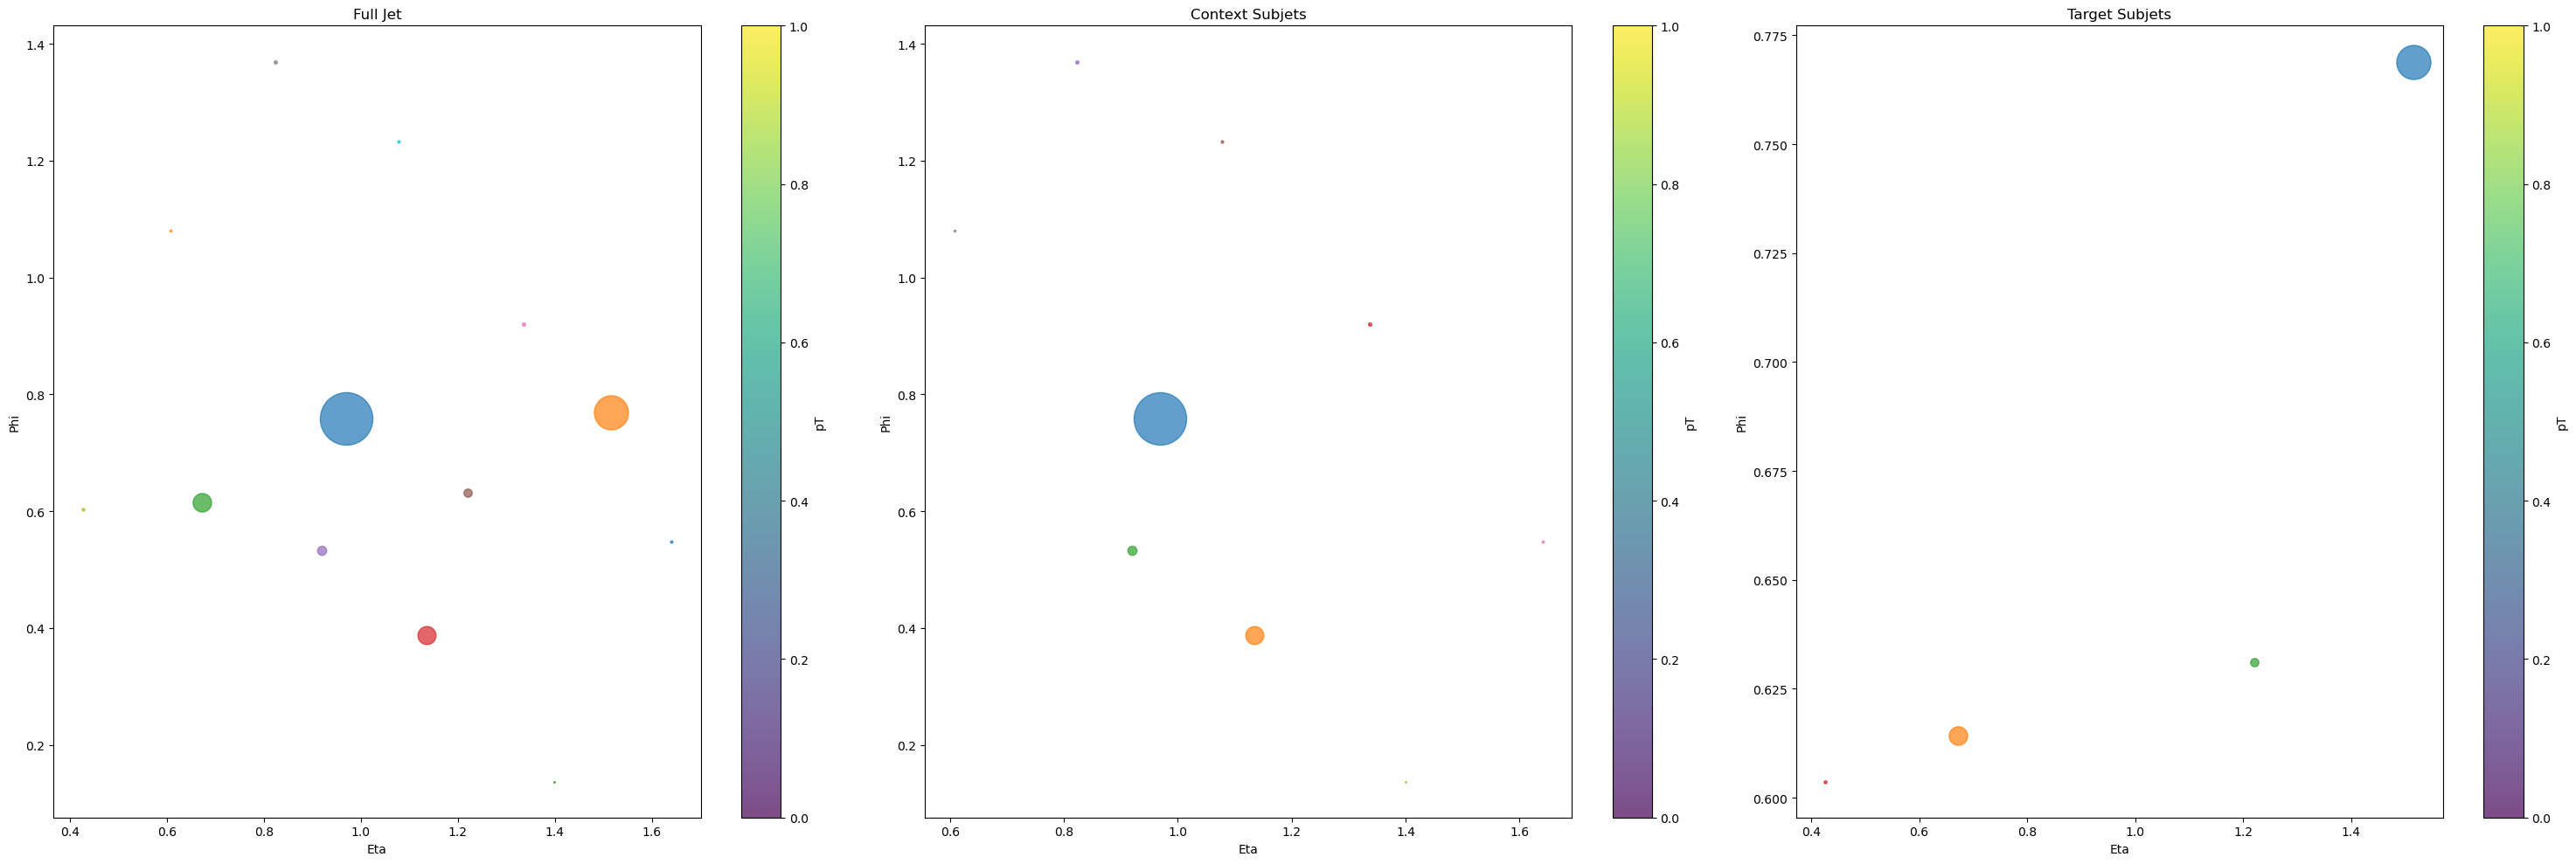

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

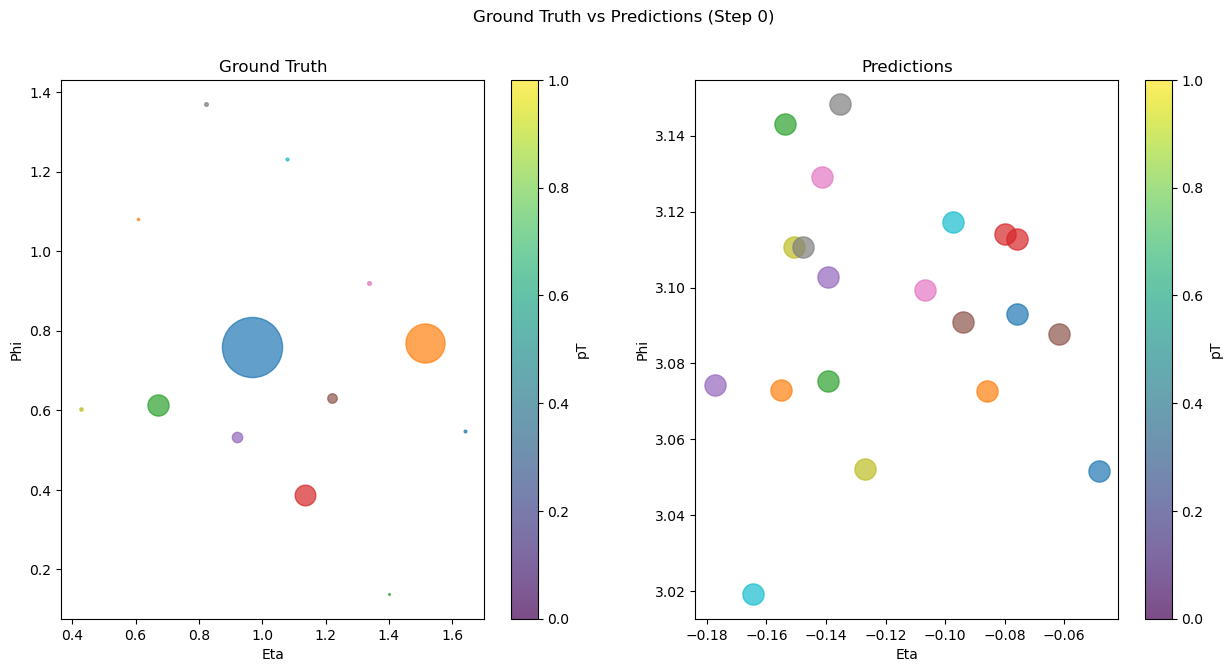

Epoch 8/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:01<00:25,  1.19it/s, loss=352]

Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])

Epoch 8, Step 0, Loss: 278.8355
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 8/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:09,  2.82it/s, loss=202]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 338.42230224609375
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 3

Epoch 8/10:  19%|█████████████████████████████▎                                                                                                                              | 6/32 [00:02<00:05,  4.49it/s, loss=207]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20,

Epoch 8/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.32it/s, loss=352]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 8/10:  28%|███████████████████████████████████████████▉                                                                                                                | 9/32 [00:02<00:03,  6.69it/s, loss=394]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 447.6908874511719
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 8/10:  34%|█████████████████████████████████████████████████████▎                                                                                                     | 11/32 [00:03<00:02,  7.59it/s, loss=435]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 9
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 

Epoch 8/10:  41%|██████████████████████████████████████████████████████████████▉                                                                                            | 13/32 [00:03<00:02,  8.10it/s, loss=443]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 11
Input shapes - Subjets: torch.Size([32, 23, 8, 30]), Subjet masks: torch.Size([32, 23]), Particle masks: torch.Size([32, 23, 30])
Creating random masks with batch_size=32, num_subjets=23
Sample context mask shape: torch.Size([23, 8, 30])
Sample target mask shape: torch.Size([23, 8, 30])
Mask shapes - Context: torch.Size([32, 23, 8, 30])

Epoch 8/10:  44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 14/32 [00:03<00:02,  8.26it/s, loss=351]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 8/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:01,  8.40it/s, loss=317]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 368.981201171875
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([22, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Si

Epoch 8/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:03<00:01,  8.52it/s, loss=191]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 16
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 8/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20/32 [00:04<00:01,  8.59it/s, loss=379]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 18
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30])

Epoch 8/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21/32 [00:04<00:01,  8.60it/s, loss=325]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 8/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  8.61it/s, loss=431]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 202.26116943359375
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.

Epoch 8/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 25/32 [00:04<00:00,  8.61it/s, loss=164]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 23
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 8/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 26/32 [00:04<00:00,  8.55it/s, loss=209]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 25
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes 

Epoch 8/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 28/32 [00:05<00:00,  8.55it/s, loss=258]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 8/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 30/32 [00:05<00:00,  8.55it/s, loss=325]

Context encoder output shape: torch.Size([32, 24, 384])
Target encoder output shape: torch.Size([32, 24, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 24, 240])
Final predicted representation shape: torch.Size([32, 24, 8, 30])
Final target representation shape: torch.Size([32, 24, 8, 30])
Predicted representation shape: torch.Size([32, 24, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 24, 384])
Target representation shape: torch.Size([32, 24, 8, 30])
Combined mask shape: torch.Size([32, 24, 8, 30])
Calculated loss: 274.4158020019531
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.87it/s, loss=109]


subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 30
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.S

Epoch 9/10:   0%|                                                                                                                                                                              | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([22, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

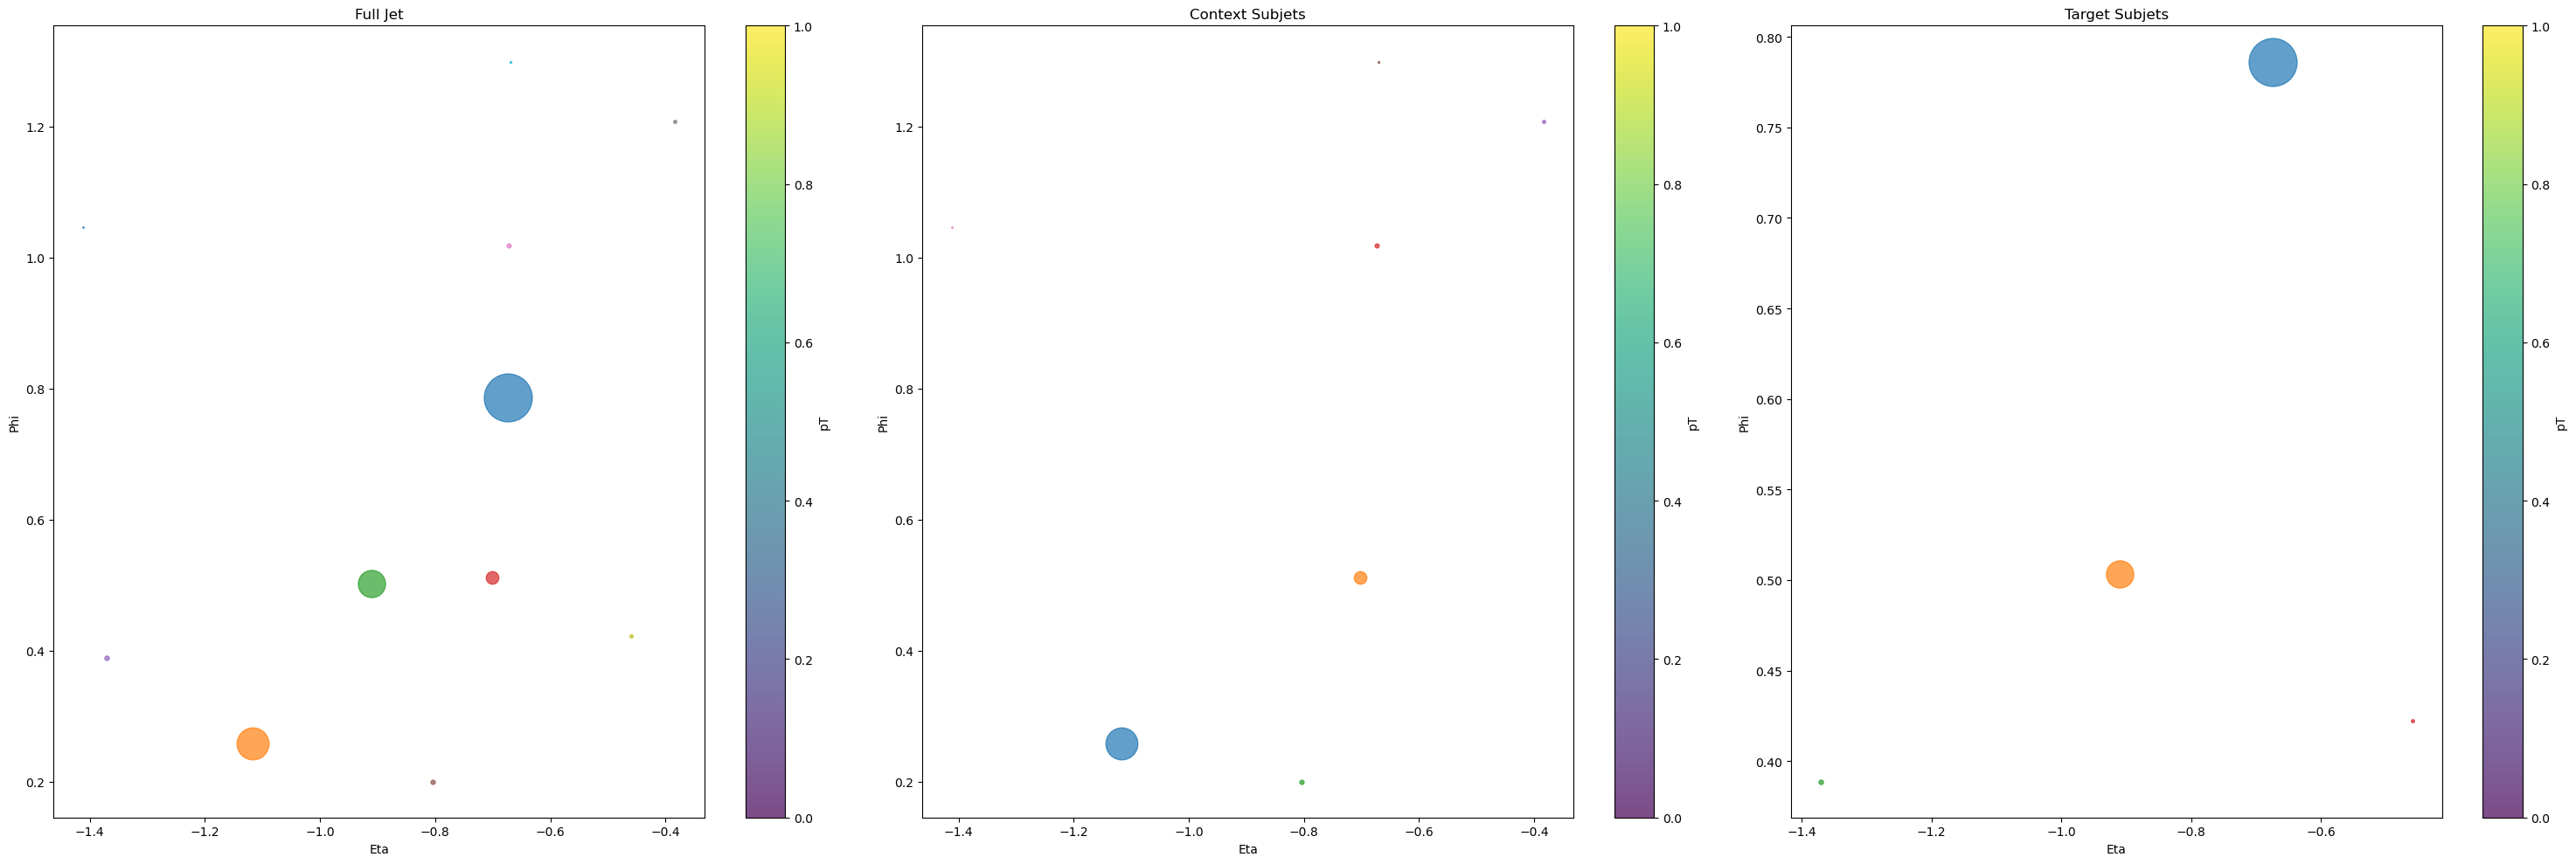

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 22, 8, 30])
Input target shape: torch.Size([32, 22, 8, 30])
Reshaped context shape: torch.Size([32, 22, 240])
Reshaped target shape: torch.Size([32, 22, 240])
Embedded context shape: torch.Size([32, 22, 384])
Embedded target shape: torch.Size([32, 22, 384])
torch.Size([32, 22, 384]) torch.Size([32, 22, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 22, 384])
Target encoder output shape: torch.Size([32, 22, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 22, 240])
Final predicted representation shape: torch.Size([32, 22, 8, 30])
Final target representation shape: torch.Size([32, 22, 8, 30])
Predicted representation shape: torch.Size([32, 22, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 22, 384])
Target representation shape: torch.Size([32, 22, 8, 30]

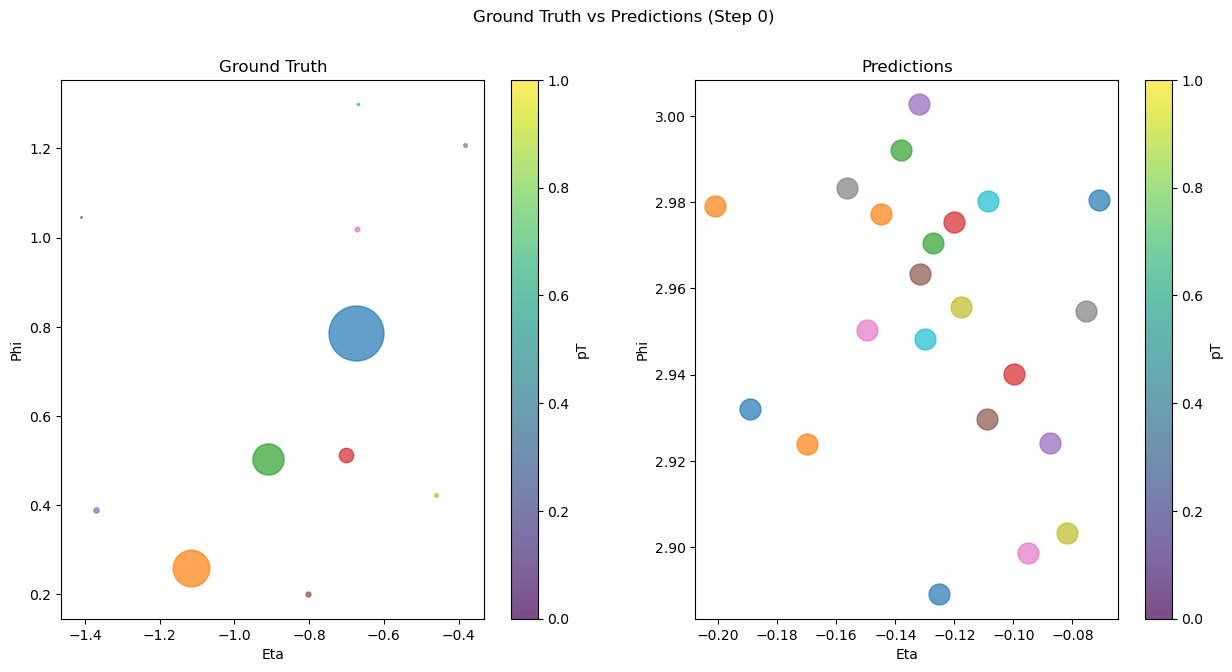

Epoch 9/10:   6%|█████████▊                                                                                                                                                  | 2/32 [00:01<00:25,  1.20it/s, loss=222]

Context representation shape: torch.Size([32, 22, 384])
Target representation shape: torch.Size([32, 22, 8, 30])

Epoch 9, Step 0, Loss: 243.5924
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torc

Epoch 9/10:  12%|███████████████████▌                                                                                                                                        | 4/32 [00:02<00:09,  2.84it/s, loss=389]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 367.7563171386719
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 9/10:  19%|█████████████████████████████▎                                                                                                                              | 6/32 [00:02<00:05,  4.65it/s, loss=310]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20,

Epoch 9/10:  22%|██████████████████████████████████▏                                                                                                                         | 7/32 [00:02<00:04,  5.47it/s, loss=217]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 6
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20


Epoch 9/10:  28%|███████████████████████████████████████████▉                                                                                                                | 9/32 [00:02<00:03,  6.79it/s, loss=411]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 9/10:  34%|█████████████████████████████████████████████████████▎                                                                                                     | 11/32 [00:03<00:02,  7.64it/s, loss=455]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 347.65496826171875
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.

Epoch 9/10:  41%|██████████████████████████████████████████████████████████████▉                                                                                            | 13/32 [00:03<00:02,  8.14it/s, loss=240]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 11
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 9/10:  47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 15/32 [00:03<00:02,  8.40it/s, loss=393]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 13
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30])

Epoch 9/10:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 16/32 [00:03<00:01,  8.48it/s, loss=353]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 9/10:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18/32 [00:03<00:01,  8.59it/s, loss=434]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 329.419677734375
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Si

Epoch 9/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20/32 [00:04<00:01,  8.61it/s, loss=300]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 18
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 9/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 22/32 [00:04<00:01,  8.59it/s, loss=250]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 20
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30])

Epoch 9/10:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 23/32 [00:04<00:01,  8.61it/s, loss=241]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 9/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 25/32 [00:04<00:00,  8.63it/s, loss=189]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 323.8336486816406
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 9/10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 27/32 [00:04<00:00,  8.66it/s, loss=267]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 25
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 9/10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 29/32 [00:05<00:00,  8.68it/s, loss=352]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 27
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30])

Epoch 9/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 30/32 [00:05<00:00,  8.67it/s, loss=336]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.94it/s, loss=733]


Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 206.9295196533203
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 31
Input

Epoch 10/10:   0%|                                                                                                                                                                             | 0/32 [00:00<?, ?it/s]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

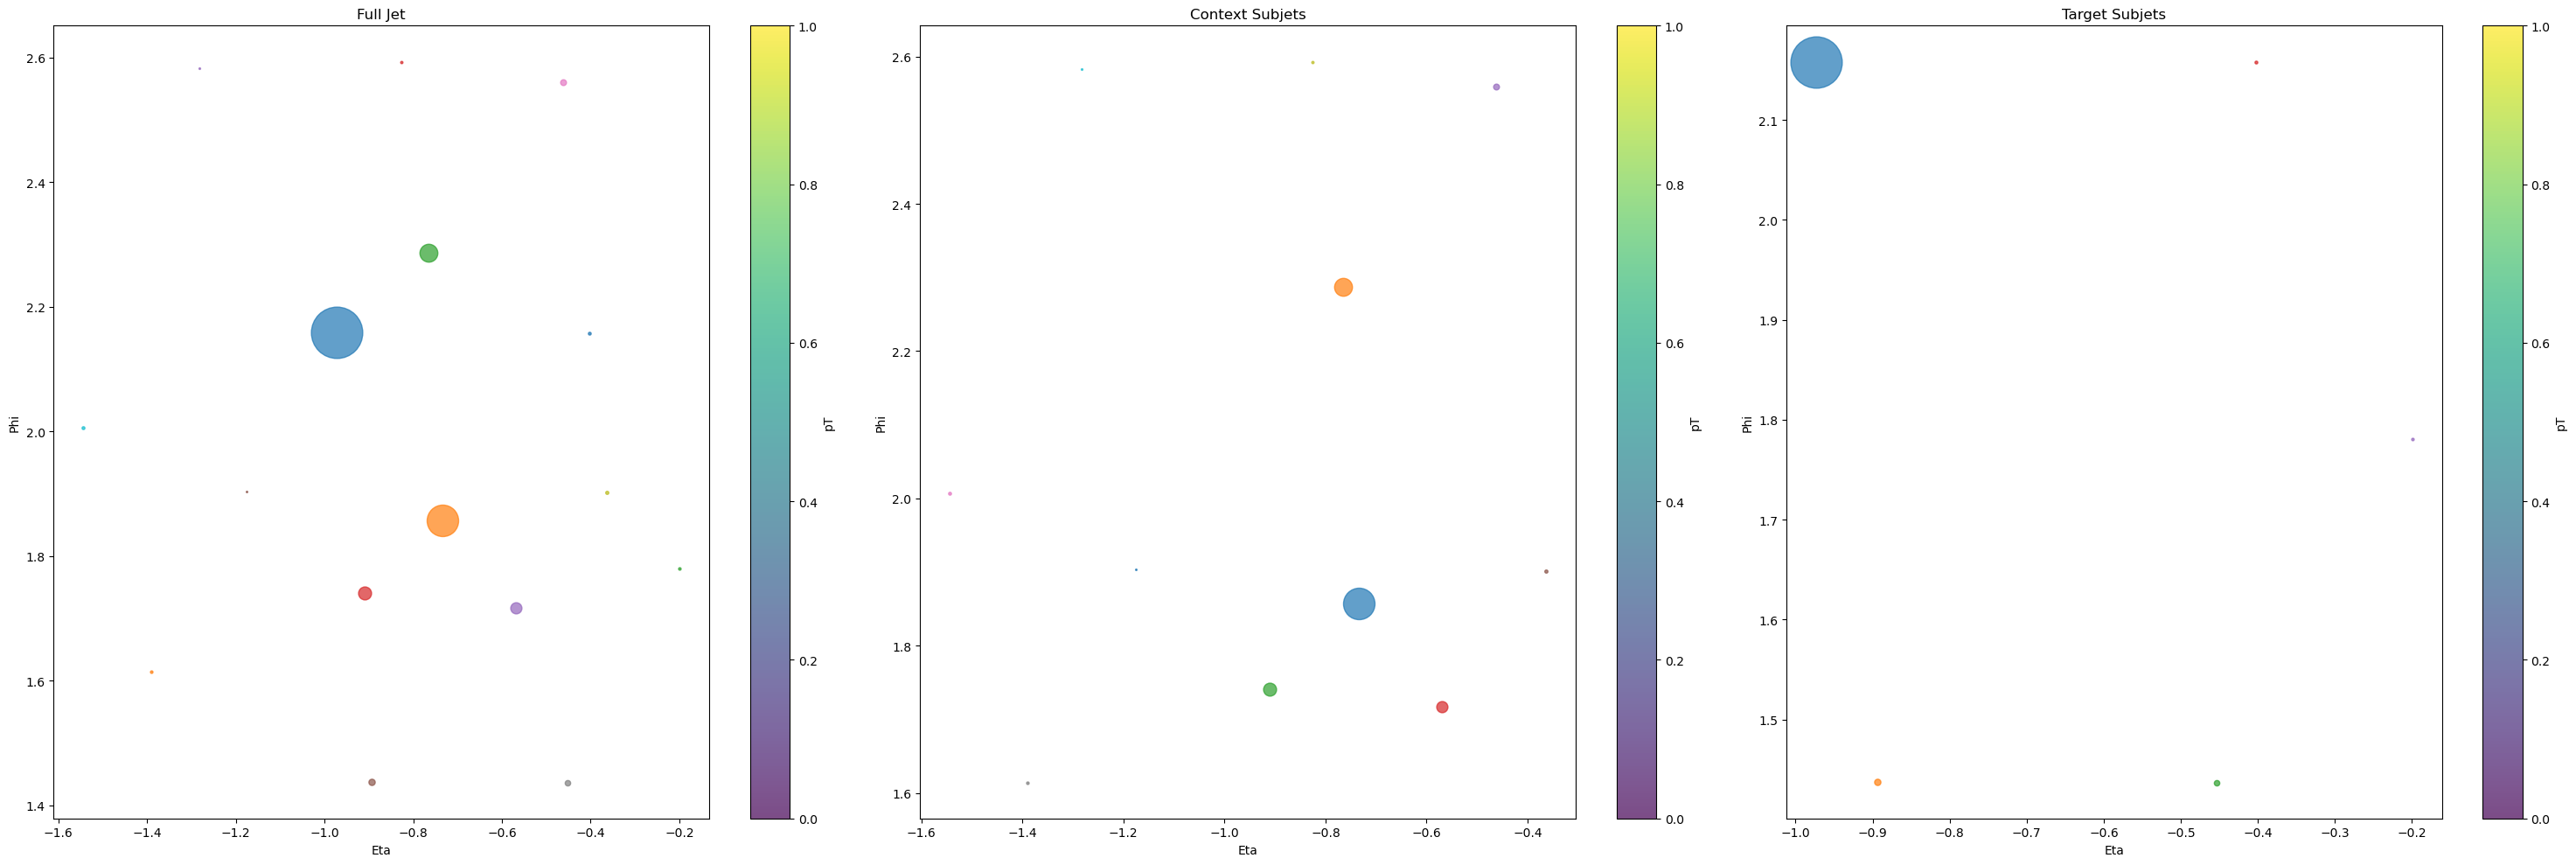

Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20, 384])
Applying context encoder
Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30]

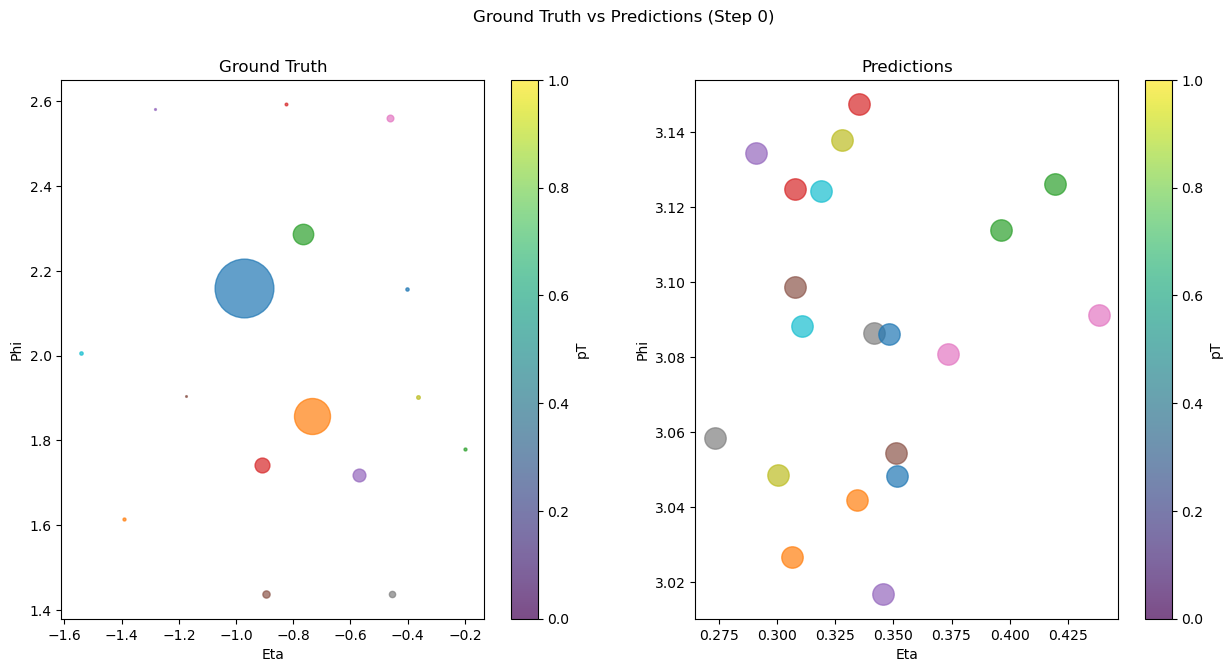

Epoch 10/10:   6%|█████████▋                                                                                                                                                 | 2/32 [00:02<00:26,  1.13it/s, loss=387]

Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])

Epoch 10, Step 0, Loss: 282.3793
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape tor

Epoch 10/10:  12%|███████████████████▍                                                                                                                                       | 4/32 [00:02<00:10,  2.71it/s, loss=302]

Applying target encoder
Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 370.8582763671875
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30

Epoch 10/10:  19%|█████████████████████████████                                                                                                                              | 6/32 [00:02<00:05,  4.50it/s, loss=342]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 4
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20,

Epoch 10/10:  22%|█████████████████████████████████▉                                                                                                                         | 7/32 [00:02<00:04,  5.34it/s, loss=397]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 6
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20


Epoch 10/10:  28%|███████████████████████████████████████████▌                                                                                                               | 9/32 [00:02<00:03,  6.71it/s, loss=292]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 10/10:  34%|████████████████████████████████████████████████████▉                                                                                                     | 11/32 [00:03<00:02,  7.62it/s, loss=456]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 495.6608581542969
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 10/10:  41%|██████████████████████████████████████████████████████████████▌                                                                                           | 13/32 [00:03<00:02,  8.12it/s, loss=329]

subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 11
Input shapes - Subjets: torch.Size([32, 21, 8, 30]), Subjet masks: torch.Size([32, 21]), Particle masks: torch.Size([32, 21, 30])
Creating random masks with batch_size=32, num_subjets=21
Sample context mask shape: torch.Size([21, 8, 30])
Sample target mask shape: torch.Size([21, 8, 30])
Mask shapes - Context: torch.Size([32, 21, 8, 30]), Target: torch.Size([32, 21, 8, 30])
Context subjets shape: torch.Size([32, 21, 8, 30])
Target subjets shape: torch.Size([32, 21, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 21, 8, 30])
Input target shape: torch.Size([32, 21, 8, 30])
Reshaped context shape: torch.Size([32, 21, 240])
Reshaped target shape: torch.Size([32, 21, 240])
Embedded context shape: torch.Size([32, 21, 384])
Embedded target shape: torch.Size([32, 21, 384])
torch.Size([32, 21, 384]) torch.Size([32, 21, 384])
Applying context encoder
Applyi

Epoch 10/10:  47%|████████████████████████████████████████████████████████████████████████▏                                                                                 | 15/32 [00:03<00:02,  8.39it/s, loss=149]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 13
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])


Epoch 10/10:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 16/32 [00:03<00:01,  8.47it/s, loss=363]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 10/10:  56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 18/32 [00:03<00:01,  8.59it/s, loss=391]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 10/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 20/32 [00:04<00:01,  8.62it/s, loss=255]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 392.5031433105469
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 10/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 22/32 [00:04<00:01,  8.64it/s, loss=300]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 20
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 10/10:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 24/32 [00:04<00:00,  8.62it/s, loss=246]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 22
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30])

Epoch 10/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 25/32 [00:04<00:00,  8.60it/s, loss=279]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([23, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shap

Epoch 10/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 27/32 [00:04<00:00,  8.63it/s, loss=280]

Context encoder output shape: torch.Size([32, 20, 384])
Target encoder output shape: torch.Size([32, 20, 384])
Applying predictor
Predictor output shape (before reshaping): torch.Size([32, 20, 240])
Final predicted representation shape: torch.Size([32, 20, 8, 30])
Final target representation shape: torch.Size([32, 20, 8, 30])
Predicted representation shape: torch.Size([32, 20, 8, 30])
Number of dimensions in predicted representation: 4
Context representation shape: torch.Size([32, 20, 384])
Target representation shape: torch.Size([32, 20, 8, 30])
Combined mask shape: torch.Size([32, 20, 8, 30])
Calculated loss: 401.1597595214844
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.S

Epoch 10/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 29/32 [00:05<00:00,  8.64it/s, loss=299]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 27
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30]), Target: torch.Size([32, 20, 8, 30])
Context subjets shape: torch.Size([32, 20, 8, 30])
Target subjets shape: torch.Size([32, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([32, 20, 8, 30])
Input target shape: torch.Size([32, 20, 8, 30])
Reshaped context shape: torch.Size([32, 20, 240])
Reshaped target shape: torch.Size([32, 20, 240])
Embedded context shape: torch.Size([32, 20, 384])
Embedded target shape: torch.Size([32, 20, 384])
torch.Size([32, 20, 384]) torch.Size([32, 20,

Epoch 10/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 31/32 [00:05<00:00,  8.64it/s, loss=373]

subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 29
Input shapes - Subjets: torch.Size([32, 20, 8, 30]), Subjet masks: torch.Size([32, 20]), Particle masks: torch.Size([32, 20, 30])
Creating random masks with batch_size=32, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([32, 20, 8, 30])

Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.80it/s, loss=208]


subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
Starting custom_collate_fn

Starting training step 31
Input shapes - Subjets: torch.Size([8, 20, 8, 30]), Subjet masks: torch.Size([8, 20]), Particle masks: torch.Size([8, 20, 30])
Creating random masks with batch_size=8, num_subjets=20
Sample context mask shape: torch.Size([20, 8, 30])
Sample target mask shape: torch.Size([20, 8, 30])
Mask shapes - Context: torch.Size([8, 20, 8, 30]), Target: torch.Size([8, 20, 8, 30])
Context subjets shape: torch.Size([8, 20, 8, 30])
Target subjets shape: torch.Size([8, 20, 8, 30])
Forwarding through model
Starting IJEPA forward pass
Input context shape: torch.Size([8, 20, 8, 30])
Input target shape: torch.Size([8, 20, 8, 30])
Reshaped context shape: torch.Size([8, 20, 240])
Reshaped target shape: torch.Size([8, 20, 240])
Embe

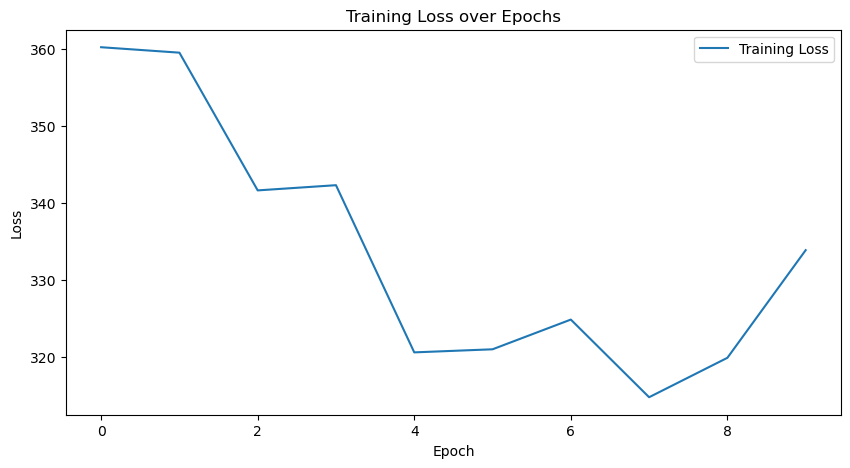

Saving model
Model saved. Starting evaluation.
Visualizing sample prediction
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets shape torch.Size([20, 8, 30])
subjets sha

ValueError: too many values to unpack (expected 4)

In [16]:
if __name__ == "__main__":
    print("Starting main program")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
        
    # Load a subset of the dataset
    try:
        print("Loading dataset")
        train_dataset = JetDataset("../data/val/val_20_30.h5", subset_size = 1000)  # Use only 1000 samples    
    except Exception as e:
        print(f"Error loading dataset: {e}")

    print("Creating DataLoader")
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

    # Initialize model
    print("Initializing model")
    model = IJEPA(input_dim=240, embed_dim=384, depth=12, num_heads=8, mlp_ratio=4.0, dropout=0.1).to(device)
    # model = IJEPA(input_dim=240, embed_dim=512, depth=16, num_heads=8, mlp_ratio=4.0, dropout=0.1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.04)

    # Training
    num_epochs = 10
    train_losses = []
    
    print(f"Starting training for {num_epochs} epochs")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=True, position=0)
    
        for step, (subjet_ftrs, subjets, pos_embs, subjet_masks, particle_masks) in enumerate(train_loader):
            subjets = subjets.to(device)
            pos_embs = pos_embs.to(device)
            subjet_masks = subjet_masks.to(device)
            particle_masks = particle_masks.to(device)
            loss = train_step(model, subjets, pos_embs, subjet_masks, particle_masks, optimizer, device, step)
            total_loss += loss
            
            progress_bar.set_postfix(loss=loss)
            progress_bar.update(1)
            
            if step % 100 == 0:
                print(f"\nEpoch {epoch+1}, Step {step}, Loss: {loss:.4f}")
        
        progress_bar.close()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    print("Training completed")

    # Visualize training loss
    print("Visualizing training loss")
    visualize_training_loss(train_losses)

    print("Saving model")
    torch.save(model.state_dict(), 'ijepa_model.pth')

    print("Model saved. Starting evaluation.")

    # Visualize a sample prediction after training
    visualize_sample_prediction(train_loader, model, device, step=num_epochs)

    print("Evaluation completed.")